<a id='back_to_top'></a>

# Table of Content

- ## [Bingo Blitz data - raw features set](#raw_features)
    - ### [Loading the data and initial data analysis](#load_data_initial_analysis)
    - ### [Understanding the different features](#understand_features)
        - #### [New Feature - Estimated Seniority](#estimated_seniority)
        - #### [Top Platform,&nbsp; Level,&nbsp;  Trstier,&nbsp;  Level bracket](#top_platform_level_trstier_level_bracket)
        - #### [Is VIP,&nbsp; Is Elite,&nbsp; Recency](#elite_vip_recency)
        - #### [Lifetime_Revenue_Net](#lifetime_revenue)
        - #### [Last 30D Revenue Net](#last30d_revenue)
        - #### [Last 90D Revenue Net](#last90d_revenue)
        - #### [Last 30D Transactions](#last30d_transactions)
        - #### [Last 30D Gross Sink,&nbsp; Last 90D Gross Sink](#sink)
        - #### [Last 30D Login Days,&nbsp; Last 90D Login Days,&nbsp; Life-time Login Days](#login_days)
        - #### [Credit Balance EOD](#credit_eod)
        - #### [Coins Balance EOD](#coins_eod)
        - #### [Number of Bingo Rounds](#bingo_rounds)
        - #### [Total Rounds Modes 1-3](#total_rounds_modes_1_3)
        - #### [Total Rounds Modes 4-6](#total_rounds_modes_4_6)

# Quick Summary 

Here is a quick summary of the data: 
- **25 features** of **different types** - numerical (continous and discrete), ordinal and nominal. 
- Very **few nan** values (cleaned) 
- In **many features** there is a **majority of users** with **zero value**. With this in mind, it is necessary to be careful and examine two things: first, whether these zeros are meaningful (e.g., in the 30 days revenue, many of the zeros are because the users have not been on the app in the last 30 days, making the zero value trivial), and second, what is the impact of the zeros on the correlations (that is, there will be strong correlation between two features where most of the users have zero value, even if such correlation doesn't exist). 
    
- **Top Platform**: most of the users, ca. 70%, are from the Google platform. An additional 20% are from Apple, 8% from Facebook, and the remaining users arrive from either Amazon, Windows, Web or PRAS.
- **Level**: the probability of finding a user at higher levels **falls exponentially** with the level. This is because of how the advancement of a user from level is desiged - while the game is the same at lower and higher levels, it takes more playing time for a user to accumulate enough tokens to advance from level 100 to level 101 than from level 10 to 11.
- **Trstier**: follows a similar exponential distribution as the level. 
- **is elite** and **is vip**: very few are elite, and even fewer are vip.
- **Recency**: The majority of users in this data set have a recency of up to 200 days or so. The decay in the counts of users with a **longer recency than 200 days** seems to follow a **power-law**. Still need to think to try and understand why only the tail behaves like a power-law, while the **larger group of recency < 200 is almost flat**. 
- **Life-time revenue**: Seems like the users who has a positive revenue follows a **power-law** distribution. If the non-zero revenue users are added, the 'kink' between the initial two data points is more pronounced, suggesting that **there is a categorical difference between the paying and non-paying users**. That is, they do not originate as part of the same distribution.
- **Last 30 days revenue**: with only the paying users - a beautiful **power-law** relation. The above figures suggests that there is a distinction between the paying and non-paying groups of users who contributed at the Last 30 Days users.
- **Last 90 days revenue**: same as with the Last 30 days revenue. 
- **Last 30 days transactions**: Here as well, the zero-transactions users don't follow the same **power-law** distribution as the users who had positive number of transactions. Logically following the last-30days revenue results. 
- **Last 30 days gross sink**: Seems like the gross sink behaves very similar to a power-law, with somewhat different powers for users with lower sink ( < 10^4) compared to users with higher sink. Both here and above for the revenue, I think that the power-law emerge from the proportionality of the required revenue or eventual sink: the more a user play, the higher will be their level, and the higher their sink and the higher the revenue they will need to invest in order to advance or just play the game.
- **Last 90 days gross sink**: very similar results to the 30 days sink. 
- **Last 30 days login days**: The distribution has two peaks: there are many users that login every day, and many users that login only once, with a parabola shape in between. 
- **Last 90 days login days**: Very similar to the 30 days login, only here the number of users with only single day login is higher. 
- **Life-time login days**: Seems like there are two main groups here: users that have up to 2000 or so login days follow one power-law, and users with higher than 2500 login-days follow a sharper decrease.  
- **Creadit balance EOD** and **Coins balance EOD**: both features follow what seems to be a power-law distribution, with a kink at the lower values of credit (coins) balance, suggesting that as for other features, there is a difference between the users that are highly engaged with the game vs. users that do not. 
- **Number of bingo rounds**: looks more like a power-law than an exponential. 
- **Total rounds modes 1 - 6**: Follow power-law distribution, with a kink at the lower values. Here as well it suggests that the behavior of the highly engaged users is different than users that are not as engaged. 

## Imports and setting global param

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sb

In [2]:
# Set Pandas to display more columns as default
pd.options.display.max_columns=30

## Functions

In [3]:
def read_data_from_pickle(file_name, sort = True, by_column = 'dim_user_gid'): 
    
    data = pd.read_pickle(file_name)
    data["dim_user_gid"].astype(int)

    print("\nA short summary of the uploaded file:")
    print("The data was loaded into a data-frame.")
    print("There are {} different rows, and {} different columns.".format(data.shape[0], data.shape[1]))
    print("There are {} unique values at the dim_user_gid column.".format(data['dim_user_gid'].nunique()))
    print("There are {} *nan* values at the dim_user_gid column.".format(data['dim_user_gid'].isnull().sum()))

    if sort:
        data = data.sort_values(by = ["dim_user_gid"])
        print("The data-frame was sorted by the dim_user_gid column.\n")
    
    return data

In [71]:
def find_users_in_both_data_and_target_frames(data_frame, target_frame, sort = True, by_column = 'dim_user_gid'):
    
    result = pd.merge(data_frame, target_frame, on = by_column)
    
    print("\nA short summary of the merge action:")
    print("The target frame was merged with the historical data frame, and it includes *only* users that appears in both.")
    print("There are {} different rows, and {} different columns.".format(result.shape[0], result.shape[1]))
    print("There are {} unique values at the dim_user_gid column.".format(result['dim_user_gid'].nunique()))
    
    if sort:
        result = result.sort_values(by = ['dim_user_gid'])
        print("The data-frame was sorted by the dim_user_gid column.\n")
    
    return result

[back to top](#back_to_top)  <a id='raw_features'></a>

## Bingo Blitz data - raw features set


#### Available user properties

- top_platform 
- level 
- trstier 
- level_bracket
- is_elite
- is_vip
- llrecency (the last time the user was seen)
- Lifetime_Revenue_Net
- Last_30D_Revenue_Net
- Last_90D_Revenue_Net
- Last_30D_Transactions
- Last_30D_Gross_Sink
- Last_90D_Gross_Sink
- Last_30D_Login_days
- Last_90D_Login_days
- credits_balance_EOD
- coins_balance_EOD
- number_of_bingo_rounds
- Life_Time_Login_Days
- total_rounds_mode_1
- total_rounds_mode_2
- total_rounds_mode_3
- total_rounds_mode_4
- total_rounds_mode_5
- total_rounds_mode_6

[back to top](#back_to_top)  <a id='load_data_initial_analysis'></a>

### Loading the data and initial data analysis 

In [5]:
# # Data with 1 million users
# file_name = "Data/data_features_1_million_users_20220915.pkl"

# Data with 5 million users
file_name = "Data/data_features_5_million_users_20220915.pkl"

In [6]:
data_for_clustering = read_data_from_pickle(file_name)
data_for_clustering.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 5000000 different rows, and 26 different columns.
There are 5000000 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



,dim_user_gid,top_platform,level,trstier,level_bracket,is_elite,is_vip,llrecency,Lifetime_Revenue_Net,Last_30D_Revenue_Net,Last_90D_Revenue_Net,Last_30D_Transactions,Last_30D_Gross_Sink,Last_90D_Gross_Sink,Last_30D_Login_days,Last_90D_Login_days,credits_balance_EOD,coins_balance_EOD,number_of_bingo_rounds,Life_Time_Login_Days,total_rounds_mode_1,total_rounds_mode_2,total_rounds_mode_3,total_rounds_mode_4,total_rounds_mode_5,total_rounds_mode_6
23899,261,Apple,74.0,2.0,lv_40_79,0,0,4,0.0000,0.0000,0.0000,0,42.0000,42.0000,2,2,23992.0,989739.0,0,72,0,0,0,0,0,0
40151,288,Google,77.0,1.0,lv_40_79,0,0,1,0.0000,0.0000,0.0000,0,0.0000,0.0000,6,17,591.0,129887.0,0,66,0,0,0,0,0,0
40152,312,Google,97.0,1.0,lv_80_119,0,0,1,0.0000,0.0000,0.0000,0,16952.0000,53355.0000,29,89,279.0,485502.0,10,136,0,0,5,0,0,0
40153,376,Google,126.0,3.0,lv_120_139,0,0,10,85.1555,0.0000,10.4930,0,0.0000,2652.0000,1,7,2278.0,2863137.0,0,306,0,0,0,0,0,0
68592,381,Google,129.0,2.0,lv_120_139,0,0,1,110.9604,0.0000,10.4930,0,450.0000,25135.0000,10,36,5698.0,1277645.0,0,307,0,0,0,0,0,0
80781,388,Apple,85.0,2.0,lv_80_119,0,0,121,3.8430,0.0000,0.0000,0,0.0000,0.0000,0,0,1414.0,4238.0,0,109,0,0,0,0,0,0
48277,391,Web,243.0,2.0,lv_200plus,0,0,1,0.0000,0.0000,0.0000,0,11580.0000,34815.0000,30,90,4.0,4128.0,5,2480,5,0,0,0,0,0
3584,427,Facebook,208.0,3.0,lv_200plus,0,0,1,0.0000,0.0000,0.0000,0,21180.0000,238137.0000,27,87,426.0,9904.0,5,1164,0,0,0,0,0,0
48278,436,Facebook,72.0,2.0,lv_40_79,0,0,41,0.0000,0.0000,0.0000,0,0.0000,772.0000,0,1,204.0,342700.0,0,165,0,0,0,0,0,0
68593,454,Google,64.0,2.0,lv_40_79,0,0,49,0.0000,0.0000,0.0000,0,0.0000,1944.0000,0,1,207.0,25913.0,0,66,0,0,0,0,0,0


In [7]:
# Checking the variable type in each column
data_for_clustering.dtypes

dim_user_gid                int64
top_platform               object
level                     float64
trstier                   float64
level_bracket              object
is_elite                    int64
is_vip                      int64
llrecency                   int64
Lifetime_Revenue_Net       object
Last_30D_Revenue_Net       object
Last_90D_Revenue_Net       object
Last_30D_Transactions       int64
Last_30D_Gross_Sink        object
Last_90D_Gross_Sink        object
Last_30D_Login_days         int64
Last_90D_Login_days         int64
credits_balance_EOD       float64
coins_balance_EOD         float64
number_of_bingo_rounds      int64
Life_Time_Login_Days        int64
total_rounds_mode_1         int64
total_rounds_mode_2         int64
total_rounds_mode_3         int64
total_rounds_mode_4         int64
total_rounds_mode_5         int64
total_rounds_mode_6         int64
dtype: object

In [8]:
# Casting the numerical variables that are registered as 'object' into a float type
data_for_clustering['Lifetime_Revenue_Net'] = data_for_clustering['Lifetime_Revenue_Net'].astype(float)
data_for_clustering['Last_30D_Revenue_Net'] = data_for_clustering['Last_30D_Revenue_Net'].astype(float)
data_for_clustering['Last_90D_Revenue_Net'] = data_for_clustering['Last_90D_Revenue_Net'].astype(float)
data_for_clustering['Last_30D_Gross_Sink'] = data_for_clustering['Last_30D_Gross_Sink'].astype(float)
data_for_clustering['Last_90D_Gross_Sink'] = data_for_clustering['Last_90D_Gross_Sink'].astype(float)

data_for_clustering.dtypes

dim_user_gid                int64
top_platform               object
level                     float64
trstier                   float64
level_bracket              object
is_elite                    int64
is_vip                      int64
llrecency                   int64
Lifetime_Revenue_Net      float64
Last_30D_Revenue_Net      float64
Last_90D_Revenue_Net      float64
Last_30D_Transactions       int64
Last_30D_Gross_Sink       float64
Last_90D_Gross_Sink       float64
Last_30D_Login_days         int64
Last_90D_Login_days         int64
credits_balance_EOD       float64
coins_balance_EOD         float64
number_of_bingo_rounds      int64
Life_Time_Login_Days        int64
total_rounds_mode_1         int64
total_rounds_mode_2         int64
total_rounds_mode_3         int64
total_rounds_mode_4         int64
total_rounds_mode_5         int64
total_rounds_mode_6         int64
dtype: object

In [9]:
# Finding if there are null values at any of the columns
columns_with_nan = data_for_clustering.columns[data_for_clustering.isna().any()].tolist()
print(columns_with_nan)

['level', 'trstier', 'credits_balance_EOD', 'coins_balance_EOD']


In [10]:
# Finding how many nan values are there in the columns with such values:  
for col in columns_with_nan:
    print("There are {} nan values in the column {}.\n".format(data_for_clustering[col].isnull().sum(), col))

There are 8432 nan values in the column level.

There are 20 nan values in the column trstier.

There are 6218 nan values in the column credits_balance_EOD.

There are 6256 nan values in the column coins_balance_EOD.



In [11]:
# Finding how many rows has at least one nan value:
print(len(data_for_clustering) - len(data_for_clustering.dropna()))

14703


In [12]:
# As there are only ca. 15k lines, out of a total of 5000k lines, with nan values, and as the number of users 
# that are in both the raw data set and the targets sets is not decreased by too much when this rows are dropped, 
# I will just drop these lines with the nan values for now (instead of doing something more specific, like fill
# cells with nan with some mean value, etc.)
data_for_clustering.dropna(inplace = True)
data_for_clustering.shape

(4985297, 26)

[back to top](#back_to_top)  <a id='understand_features'></a>

### Understanding the different features

In [13]:
def hist_of_numerical_feature(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    plt.figure(figsize=figure_size)
    n, bins, patches = plt.hist(x, bins=n_bins, edgecolor='black')
    ticks = 0.5 * np.diff(bins) + bins[:-1]
    plt.xticks(ticks, np.ceil(ticks))
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_xticks()
    # using format string '{:.0f}' here but you can choose others
    plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)

    # Set x-axis label
    plt.xlabel(column, labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

In [14]:
def bar_plot_of_feature(data_frame, column, x_labels_sorted = []):
    
    if x_labels_sorted:
        ax = data_frame[column].value_counts().reindex(x_labels_sorted).plot(kind='bar',
                                                                             figsize=(10,6))
        
    else:
        ax = data_frame[column].value_counts().plot(kind='bar',
                                                    figsize=(10,6))
        
    ax.set_xlabel(column, labelpad=20, size=16)
    ax.set_ylabel("Frequency", labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)
    plt.show() 

In [15]:
def get_basic_feature_char(data_frame, column):
    
    num_of_unique_values = data_frame[column].unique().size
    min_value = data_frame[column].min()
    max_value = data_frame[column].max()
    
    return num_of_unique_values, min_value, max_value

In [16]:
def get_hist_info(x, n_bins): 
    
    n, bins, patches = plt.hist(x, bins=n_bins)
    plt.close()

    return n ,bins, patches

In [17]:
def fit_linear(bins_center, counts, start_at):
    
    model = np.polyfit(bins_center[start_at:], np.log10(counts[start_at:] + 1), 1)  # The + 1 is to avoid log of zero
    slope = model[0]
    intercept = model[1]
    
    return slope, intercept

In [18]:
def plot_log_scale(data_frame, column, n_bins, start_at = 0, figure_size = (10, 6)):
    
    x = data_frame[column].to_numpy()
    counts, bins, patches = get_hist_info(x, n_bins)
    bins_center = 0.5 * np.diff(bins) + bins[:-1]
    slope, intercept = fit_linear(bins_center, counts, start_at)
    
    plt.figure(figsize=figure_size)
        
    plt.scatter(bins_center, np.log10(counts + 1))  # The + 1 is to avoid log of zero
    plt.plot(bins_center[start_at:], [(slope*k + intercept) for k in bins_center[start_at:]])
    plt.text(np.max(bins_center)*0.75, np.max(np.log10(counts + 1)*0.9), 'Slope = {:.2}'.format(slope), size=16)  # The + 1 is to avoid log of zero

    plt.xticks(bins_center, np.ceil(bins_center))
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_xticks()
    # using format string '{:.0f}' here but you can choose others
    plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)

    # Set x-axis label
    plt.xlabel(column, labelpad=20, size=16)
    plt.ylabel('$log_{10}$ (counts) ', labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

In [19]:
def plot_loglog_scale(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    counts, bins, patches = get_hist_info(x, n_bins)
    bins_center = 0.5 * np.diff(bins) + bins[:-1]
    
    plt.figure(figsize=figure_size)
        
    plt.loglog(bins_center, counts, '.-')

    plt.xlabel('$log_{10}$' + '({}) '.format(column), labelpad=20, size=16)
    plt.ylabel('$log_{10}$ (counts) ', labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)
    
    plt.show()

In [20]:
def plot_data_by_index(data_frame, column, marker_size = 0.5, figure_size = (10, 6)): 
    
    plt.figure(figsize=figure_size)
    plt.plot(range(data_frame[column].shape[0]), data_frame[column], '.', markersize = marker_size)
    plt.xlabel('Index in Data', labelpad=20, size=16)
    plt.ylabel(column, labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

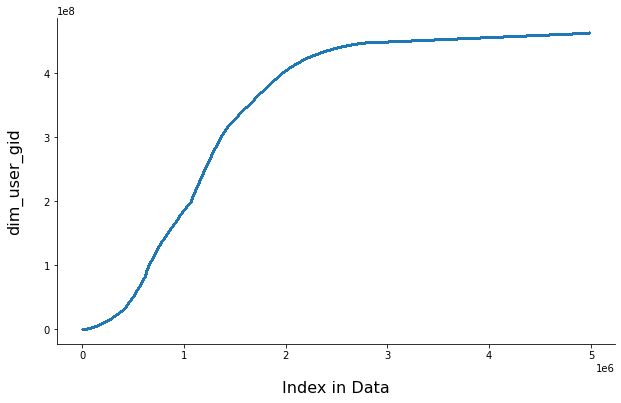

In [21]:
plot_data_by_index(data_for_clustering, 'dim_user_gid')

The data is organized by install date. That is, at the lower indices of the data there are users with small dim_user_gid, and these are users that installed the app a long time ago (e.g., the user with the dim_user_gid = 558 was probably one of the first users to ever install the app), while users at the higher indices are users that installed the app only recently. 

This observation has strong implications to the data-analysis (in the calculation of the correlations and mutual information, for example). 

[back to top](#back_to_top)  <a id='estimated_seniority'></a>

## New Feature - Estimated Seniority

In [22]:
# First, estimating the max number of login days for a given set of users 
max_login_days = []

# Choice is for groups of 100 users, as to expedite the calculations, but still maintain an accurate estimate. 
period = 100

for k in range(data_for_clustering.shape[0]):
    if k%period == 0: 
        if (k+period-1) > data_for_clustering.shape[0]:
            max_login_days.append(np.max(data_for_clustering['Life_Time_Login_Days'][k:]))           
        else:
            max_login_days.append(np.max(data_for_clustering['Life_Time_Login_Days'][k:(k+period-1)]))

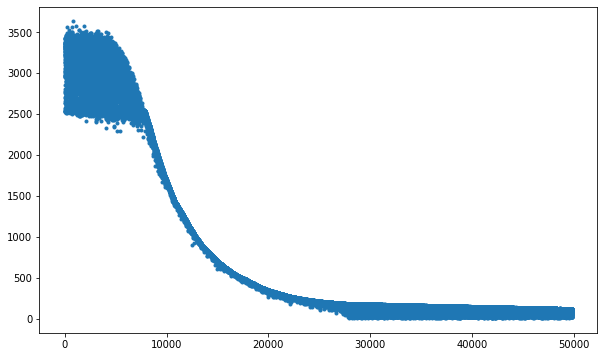

In [23]:
plt.figure(figsize = (10,6))
plt.plot(max_login_days, '.')
plt.show()

In [24]:
# Smoothing the estimate 
adjusted_max_login_days = [max_login_days[0]]

for indx, elem in enumerate(max_login_days): 
    if indx > 0: 
    
        if all([item < elem for item in adjusted_max_login_days]):
            adjusted_max_login_days = [elem for i in range(len(adjusted_max_login_days))]
            adjusted_max_login_days.append(elem)

        else: 
            dummy = next((ind for ind, item in enumerate(adjusted_max_login_days) if item < elem), None)
            if dummy == None: 
                adjusted_max_login_days.append(elem)
            else: 
                adjusted_max_login_days = [elem if ind >= dummy-1 else adjusted_max_login_days[ind] for ind in range(len(adjusted_max_login_days))]
                adjusted_max_login_days.append(elem)

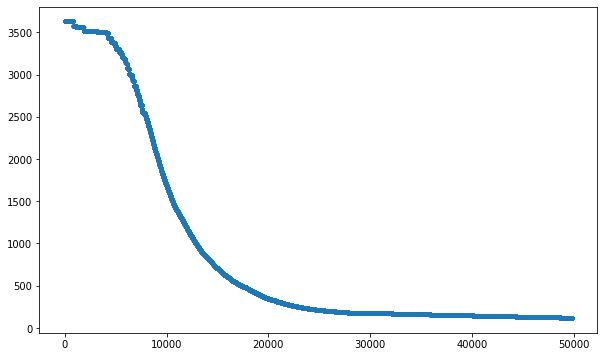

In [25]:
plt.figure(figsize = (10,6))
plt.plot(adjusted_max_login_days, '.')
plt.show()

In [26]:
# # This would be the code for having a per-user accuracy, but it just takes too long for data-sets with many users. 
# # Hence the version above of calculation over groups of users. 
# adjusted_max_login_days = [data_for_clustering['Life_Time_Login_Days'][0]]

# for indx, elem in enumerate(data_for_clustering['Life_Time_Login_Days']): 
#     if indx > 0: 
    
#         if all([item < elem for item in adjusted_max_login_days]):
#             adjusted_max_login_days = [elem for i in range(len(adjusted_max_login_days))]
#             adjusted_max_login_days.append(elem)

#         else: 
#             dummy = next((ind for ind, item in enumerate(adjusted_max_login_days) if item < elem), None)
#             if dummy == None: 
#                 adjusted_max_login_days.append(elem)
#             else: 
#                 adjusted_max_login_days = [elem if ind >= dummy-1 else adjusted_max_login_days[ind] for ind in range(len(adjusted_max_login_days))]
#                 adjusted_max_login_days.append(elem)

In [26]:
est_seniority = []
for index, elem in enumerate(adjusted_max_login_days): 
    [est_seniority.append(elem) for k in range(period)]
    
est_seniority = est_seniority[:data_for_clustering.shape[0]]
print(len(est_seniority))

4985297


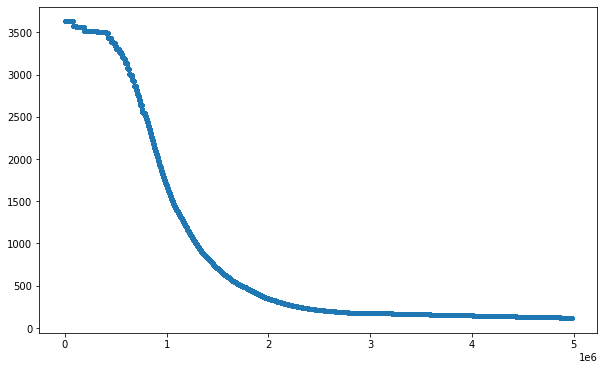

In [27]:
plt.figure(figsize = (10,6))
plt.plot(est_seniority, '.')
plt.show()

**Questions** following this graph:   
- Why is there an inflection point in the seniority? that is, only ca. 1.8 million users with seniroty of 500-3500 days, and ca. 3.2 users with seniority of 100-500. Has the app became a lot more popular in the last two years because of the, e.g., corona? 
- Can we get the actual seniority (install date) from the vertica? (I didn't see it in the list of available features from the vertica we downloaded the data from). 


In [28]:
data_for_clustering.insert(1, 'est_seniority', est_seniority)
# data_for_clustering.rename(columns = {'seniority':'est_seniority'}, inplace = True)

In [29]:
data_for_clustering.head(10)

,dim_user_gid,est_seniority,top_platform,level,trstier,level_bracket,is_elite,is_vip,llrecency,Lifetime_Revenue_Net,Last_30D_Revenue_Net,Last_90D_Revenue_Net,Last_30D_Transactions,Last_30D_Gross_Sink,Last_90D_Gross_Sink,Last_30D_Login_days,Last_90D_Login_days,credits_balance_EOD,coins_balance_EOD,number_of_bingo_rounds,Life_Time_Login_Days,total_rounds_mode_1,total_rounds_mode_2,total_rounds_mode_3,total_rounds_mode_4,total_rounds_mode_5,total_rounds_mode_6
23899,261,3628,Apple,74.0,2.0,lv_40_79,0,0,4,0.0000,0.0,0.000,0,42.0,42.0,2,2,23992.0,989739.0,0,72,0,0,0,0,0,0
40151,288,3628,Google,77.0,1.0,lv_40_79,0,0,1,0.0000,0.0,0.000,0,0.0,0.0,6,17,591.0,129887.0,0,66,0,0,0,0,0,0
40152,312,3628,Google,97.0,1.0,lv_80_119,0,0,1,0.0000,0.0,0.000,0,16952.0,53355.0,29,89,279.0,485502.0,10,136,0,0,5,0,0,0
40153,376,3628,Google,126.0,3.0,lv_120_139,0,0,10,85.1555,0.0,10.493,0,0.0,2652.0,1,7,2278.0,2863137.0,0,306,0,0,0,0,0,0
68592,381,3628,Google,129.0,2.0,lv_120_139,0,0,1,110.9604,0.0,10.493,0,450.0,25135.0,10,36,5698.0,1277645.0,0,307,0,0,0,0,0,0
80781,388,3628,Apple,85.0,2.0,lv_80_119,0,0,121,3.8430,0.0,0.000,0,0.0,0.0,0,0,1414.0,4238.0,0,109,0,0,0,0,0,0
48277,391,3628,Web,243.0,2.0,lv_200plus,0,0,1,0.0000,0.0,0.000,0,11580.0,34815.0,30,90,4.0,4128.0,5,2480,5,0,0,0,0,0
3584,427,3628,Facebook,208.0,3.0,lv_200plus,0,0,1,0.0000,0.0,0.000,0,21180.0,238137.0,27,87,426.0,9904.0,5,1164,0,0,0,0,0,0
48278,436,3628,Facebook,72.0,2.0,lv_40_79,0,0,41,0.0000,0.0,0.000,0,0.0,772.0,0,1,204.0,342700.0,0,165,0,0,0,0,0,0
68593,454,3628,Google,64.0,2.0,lv_40_79,0,0,49,0.0000,0.0,0.000,0,0.0,1944.0,0,1,207.0,25913.0,0,66,0,0,0,0,0,0


In [31]:
# data_for_clustering.to_pickle("Data/data_features_5_million_users_20220915_cleaned_with_Seniority.pkl")

## Compare estimated seniority to the actual seniority

In [30]:
file_name_seniority = "Data/data_install_date_and_seniority.pkl"

In [83]:
# Loading the data that includes the install dates and the actual seniority of each user.
# The seniority column was calculated from the first install date ('First_Install_ts' column) and the date the 
# training data was downloaded from the vertica (in this case it was the 15-09-2022). 
data_install_date = pd.read_pickle(file_name_seniority)
data_install_date = data_install_date.sort_values(by = ['UserId'])
data_install_date.head(10)

,UserId,First_Install_ts,seniority
698968,10,2014-07-14 23:28:22,2985
176790,175,2010-08-12 00:00:00,4417
125986,176,2010-08-13 00:00:00,4416
158490,177,2010-08-13 00:00:00,4416
85356,179,2010-08-13 00:00:00,4416
150364,180,2010-08-14 00:00:00,4415
698969,181,2010-08-14 00:00:00,4415
125987,182,2010-08-14 00:00:00,4415
176791,186,2010-12-15 00:00:00,4292
93482,214,2014-07-14 23:32:30,2985


In [84]:
# Changing the UserId to dim_user_gid, so it will be easier to merge the two data-frames that were originated from 
# two different vericas. 
data_install_date.rename(columns = {'UserId':'dim_user_gid'}, inplace = True)
data_install_date.head(10)

,dim_user_gid,First_Install_ts,seniority
698968,10,2014-07-14 23:28:22,2985
176790,175,2010-08-12 00:00:00,4417
125986,176,2010-08-13 00:00:00,4416
158490,177,2010-08-13 00:00:00,4416
85356,179,2010-08-13 00:00:00,4416
150364,180,2010-08-14 00:00:00,4415
698969,181,2010-08-14 00:00:00,4415
125987,182,2010-08-14 00:00:00,4415
176791,186,2010-12-15 00:00:00,4292
93482,214,2014-07-14 23:32:30,2985


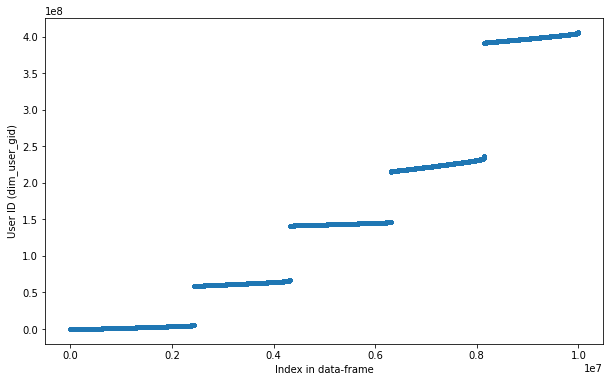

In [85]:
# Looking at the user id values. 
fig = plt.figure(figsize = (10, 6))
plt.plot(range(data_install_date.shape[0]), data_install_date["dim_user_gid"], '.')
plt.xlabel('Index in data-frame')
plt.ylabel('User ID (dim_user_gid)')
plt.show()

The user IDs are seperated into several batches with increasing number of digits. Seems like that the more users joined the app, and in order to keep them as identifiable as possible, hash numbers with increasing length were used.

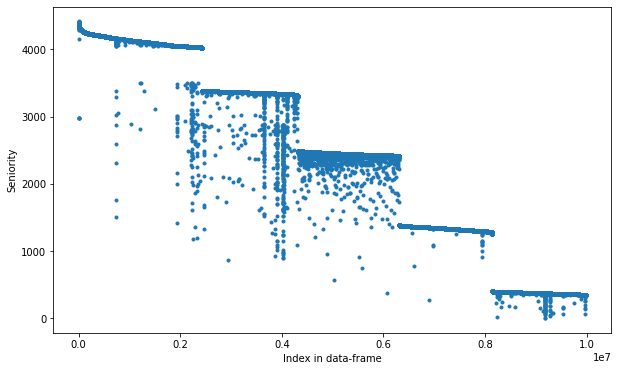

In [86]:
fig = plt.figure(figsize = (10, 6))
plt.plot(range(data_install_date.shape[0]), data_install_date["seniority"], '.')
plt.xlabel('Index in data-frame')
plt.ylabel('Seniority')
plt.show()

The seniority is decreasing with the increasing index, as expected. The batches are observed here as well, as it seems that the users here were chosen partially random from the vertica. There are a few cases that breaks the monotony of the relation, the reason for this is unknown to me yet.  

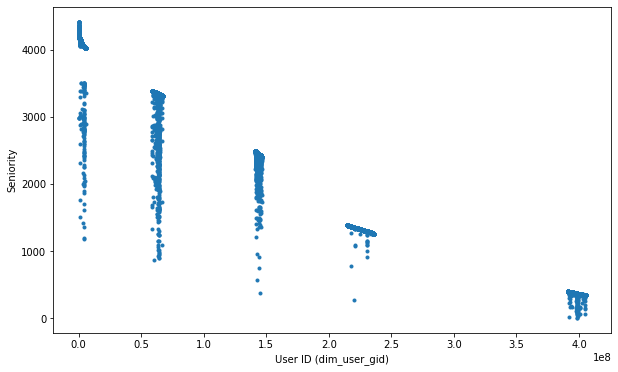

In [87]:
fig = plt.figure(figsize = (10, 6))
plt.plot(data_install_date["dim_user_gid"], data_install_date["seniority"], '.')
plt.xlabel('User ID (dim_user_gid)')
plt.ylabel('Seniority')
plt.show()

Plotting the seniority vs. the user-ids shows that decreasing expected decreasing relation (with a minority of points that break this relation, appearing as dropping rain from a cloud). 

In [88]:
def find_users_in_both_data_and_target_frames(data_frame, target_frame, sort = True, by_column = 'dim_user_gid'):
    
    result = pd.merge(data_frame, target_frame, on = by_column)
    # keeping only the seniority columns
    result = result[['dim_user_gid', 'seniority', 'est_seniority']]
    
    print("\nA short summary:")
    print("There are {} different rows, and {} different columns.".format(result.shape[0], result.shape[1]))
    print("There are {} *nan* values at the dim_user_gid column.".format((result.shape[0] - result['dim_user_gid'].count())))
    print("There are {} unique values at the dim_user_gid column.".format(result['dim_user_gid'].nunique()))
    
    result = result.drop_duplicates(subset=["dim_user_gid"], keep='last')
    if sort:
        result = result.sort_values(by = ['dim_user_gid'])
        
    print("\nKeeping only the last entry of each duplicate.\nThe end data frame has {} rows.".format(result.shape[0]))
    print("It was sorted by the dim_user_gid column.\n")
    
    return result

In [89]:
# Finding the users that exist in both data frames - the data used for clustering, and the data with 
# the install dates
seniority_df = find_users_in_both_data_and_target_frames(data_for_clustering, data_install_date)


A short summary:
There are 288972 different rows, and 3 different columns.
There are 0 *nan* values at the dim_user_gid column.
There are 288972 unique values at the dim_user_gid column.

Keeping only the last entry of each duplicate.
The end data frame has 288972 rows.
It was sorted by the dim_user_gid column.



Only ca. 3*10^5 out of the 10^7 users with install dates and 0.5*10^7 users for clustering were found in both data frames. This is only 1.5-3%. So quite sparse. 

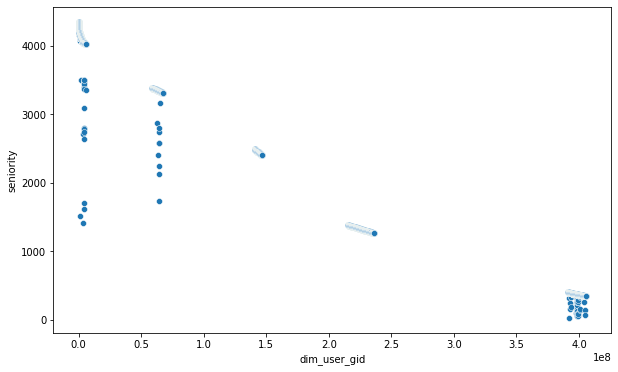

In [80]:
fig = plt.figure(figsize = (10, 6))
sb.scatterplot(x = seniority_df.columns[0], 
               y = seniority_df.columns[1], 
               data = seniority_df)

plt.show()

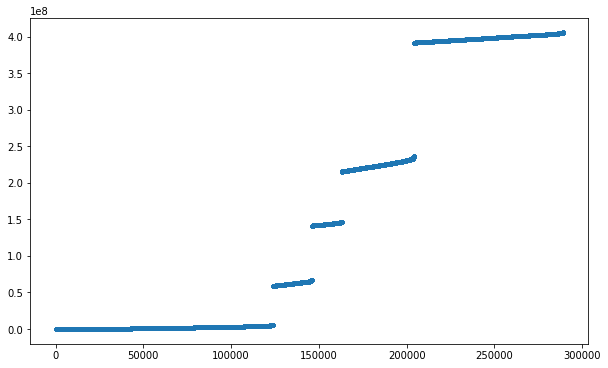

In [81]:
fig = plt.figure(figsize = (10, 6))
plt.plot(range(seniority_df.shape[0]), seniority_df["dim_user_gid"], '.')
plt.show()

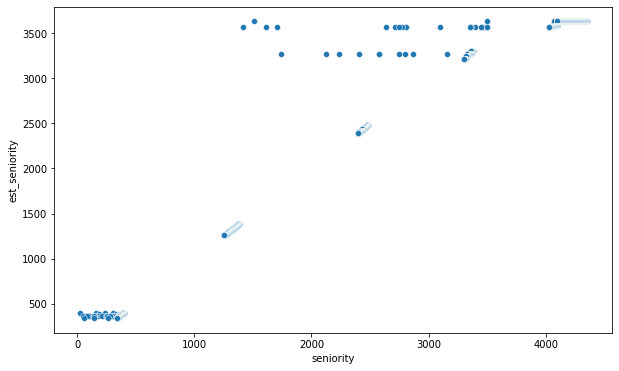

In [82]:
fig = plt.figure(figsize = (10, 6))
sb.scatterplot(x = seniority_df.columns[1], 
               y = seniority_df.columns[2], 
               data = seniority_df)

plt.show()

Finally, the figure that shows that the estimated seniority is quite a good estimate for the seniority. There are a few points for which the estimated seniority is an over-estimate, but these are the same users that their seniority and user-id do not match well (as seen in the above figures). 

[back to top](#back_to_top)  <a id='top_platform_level_trstier_level_bracket'></a>

#### Top Platform

In [32]:
unique_platforms = data_for_clustering['top_platform'].unique().size
print("The users in this data set are from {} different platforms.".format(unique_platforms))

The users in this data set are from 7 different platforms.


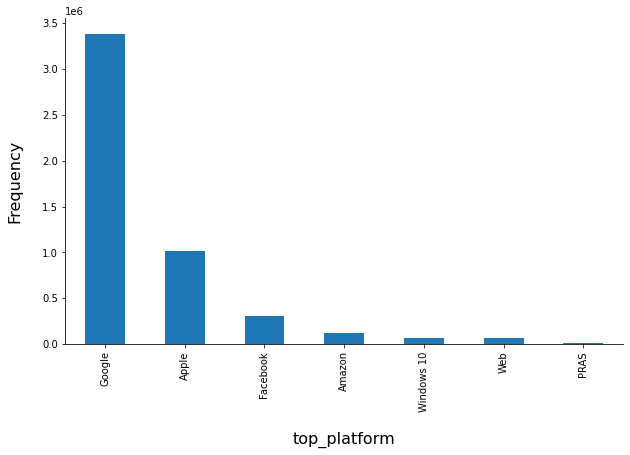

In [33]:
bar_plot_of_feature(data_for_clustering, 'top_platform')

Most of the users, ca. 70%, are from the Google platform. An additional 20% are from Apple, 8% from Facebook, and the remaining users arrive from either Amazon, Windows, Web or PRAS. 

#### level

In [34]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "level")

print("The users in this data set span {} different levels.".format(num_of_unique_values))
print("The lowest level is: {}\nThe highest level is: {}".format(min_value, max_value))

The users in this data set span 1156 different levels.
The lowest level is: 1.0
The highest level is: 1493.0


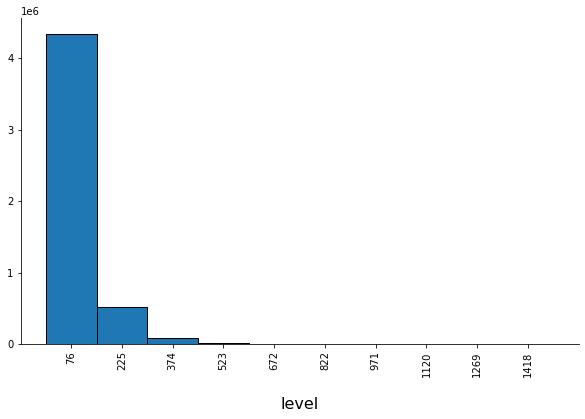

In [35]:
n_bins = 10
hist_of_numerical_feature(data_for_clustering, 'level', n_bins)

The vast majority are users at the lowest levels, with only a fraction of the users at level 300 and above. 

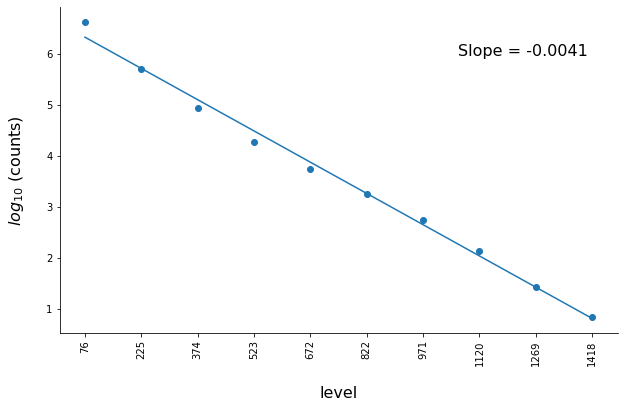

In [36]:
plot_log_scale(data_for_clustering, 'level', n_bins)

Plotting the data with the y-axis in log scale, it is clear that the probability of finding a user at higher levels falls exponentially with the level.

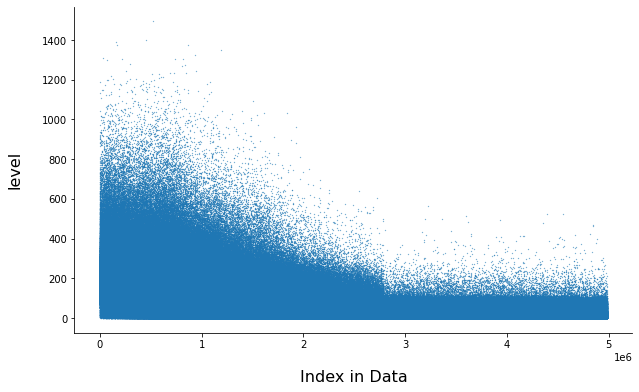

In [37]:
plot_data_by_index(data_for_clustering, 'level')

As the users are organized by seniority (install date), it make sense that users that are on the app for longer would be able to reach higher levels than newer users. 
The observed 'cut' at around data point 2.8 million may represent an event in time that is not known yet. For example, some change in the definition of the level, or the app, that made it harder for users to reach the highest level of 800 and above. 

#### trstier

In [38]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "trstier")

print("The users in this data set span {} different tiers.".format(num_of_unique_values))
print("The lowest tier is: {}\nThe highest tier is: {}".format(min_value, max_value))

The users in this data set span 7 different tiers.
The lowest tier is: 1.0
The highest tier is: 7.0


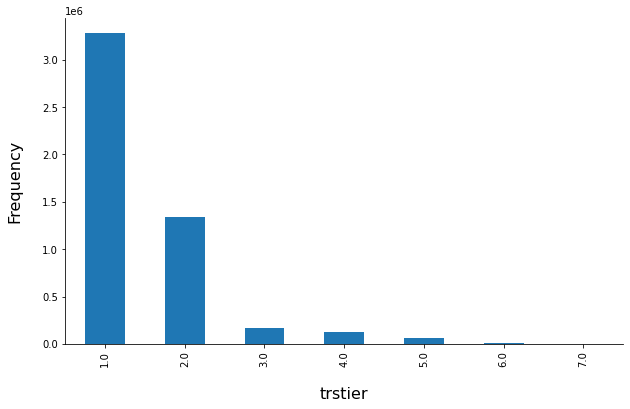

In [39]:
bar_plot_of_feature(data_for_clustering, 'trstier')

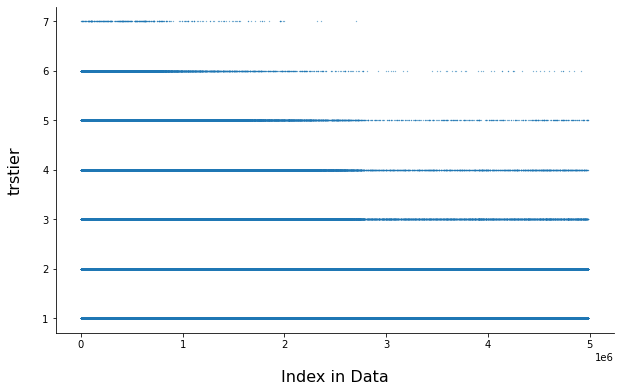

In [40]:
plot_data_by_index(data_for_clustering, 'trstier')

In accordance with lower indices means users who installed the app earlier in time, it make sense that newer users (higher indices) have not had enough playing time to reach the higher tiers.  

#### level_bracket

In [41]:
unique_values = data_for_clustering['level_bracket'].unique().size
print("The users in this data set are from {} different level brackets.".format(unique_values))

The users in this data set are from 10 different level brackets.


In [42]:
print(data_for_clustering['level_bracket'].unique())

['lv_40_79' 'lv_80_119' 'lv_120_139' 'lv_200plus' 'lv_170_199'
 'lv_140_169' 'lv_20_39' 'lv_01_07' 'unknown' 'lv_08_19']


In [43]:
sorted_level_bracket = ['lv_01_07', 'lv_08_19', 'lv_20_39', 'lv_40_79', 'lv_80_119', 'lv_120_139', 'lv_140_169', 'lv_170_199', 'lv_200plus', 'unknown']

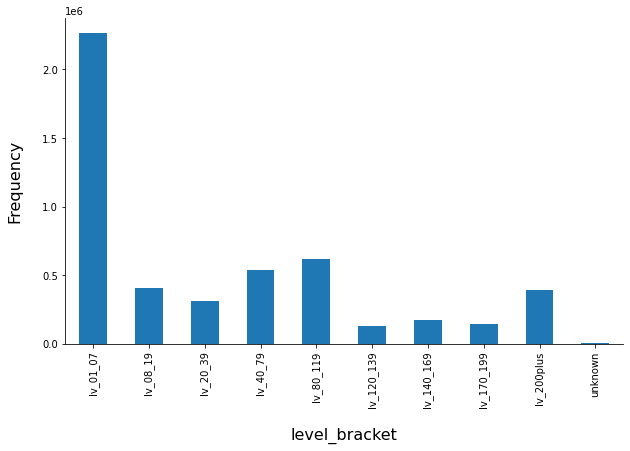

In [44]:
bar_plot_of_feature(data_for_clustering, 'level_bracket', x_labels_sorted = sorted_level_bracket)

About 50% of the users are at the 01 to 07 level bracket. Each of the remaning brackets has 5-10% of the users. 

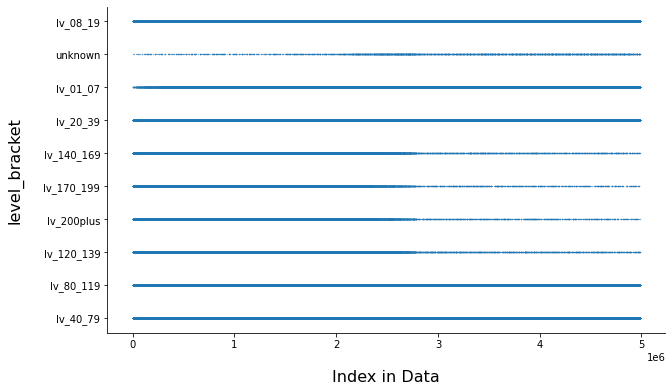

In [45]:
plot_data_by_index(data_for_clustering, 'level_bracket')

Same here: users with smaller index (earlier install dates) are more likely to be at higher level bracket. 

[back to top](#back_to_top)  <a id='elite_vip_recency'></a>

#### is_elite

In [46]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "is_elite")

print("The users in this data set are either elite, or not.".format(num_of_unique_values))

The users in this data set are either elite, or not.


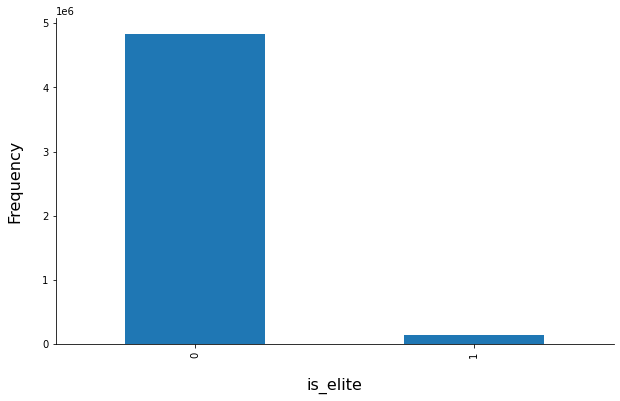

In [47]:
bar_plot_of_feature(data_for_clustering, 'is_elite')

The vast majority of the users are not elite. 

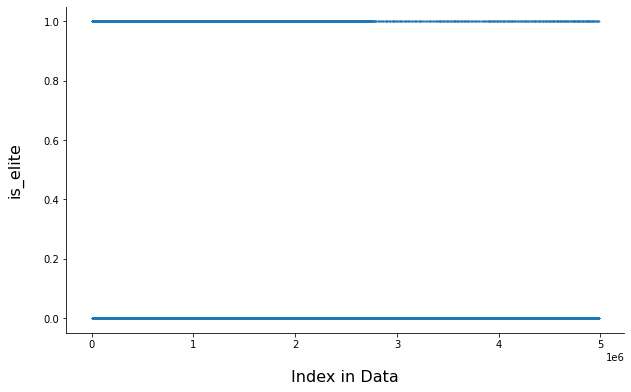

In [48]:
plot_data_by_index(data_for_clustering, 'is_elite')

As being elite is probably related to level, it also make sense that the density of elite users is higher at the smallers indices (users with earlier install dates). 

#### is_vip

In [49]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "is_vip")

print("The users in this data set are either vip, or not.".format(num_of_unique_values))

The users in this data set are either vip, or not.


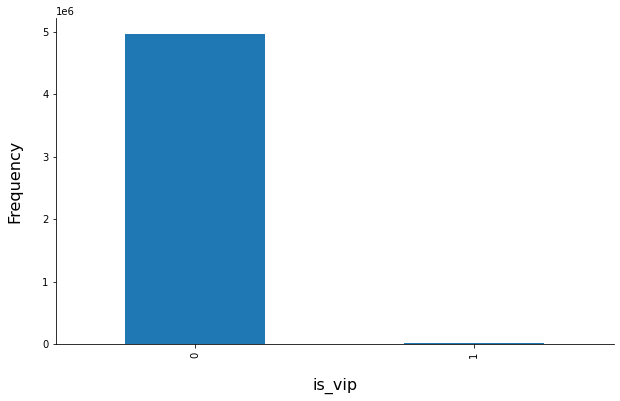

In [50]:
bar_plot_of_feature(data_for_clustering, 'is_vip')

Even fewer users are considered as VIP.

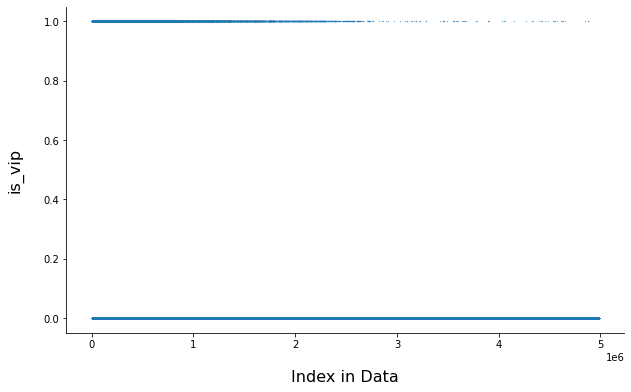

In [51]:
plot_data_by_index(data_for_clustering, 'is_vip')

Also for the vip tag, users with smaller indices (earlier install dates) are more likely to be a vip than users with higher indices (later install dates). 

#### llrecency

In [52]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "llrecency")

print("The recency of the users in this data set span {} different values.".format(num_of_unique_values))
print("The shortest time is: {} (in days)\nThe longest time is: {} (in days)".format(min_value, max_value))

The recency of the users in this data set span 1579 different values.
The shortest time is: 1 (in days)
The longest time is: 2540 (in days)


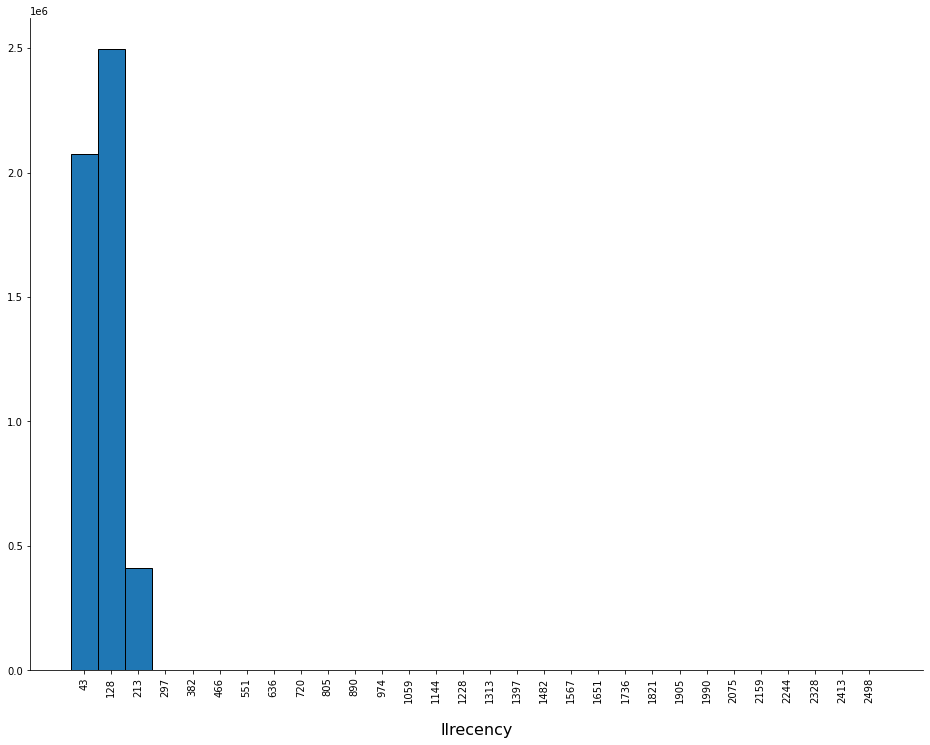

In [53]:
n_bins = 30
figsize = (16, 12)
hist_of_numerical_feature(data_for_clustering, 'llrecency', n_bins, figsize)

Very few of the users in the data set has not been playing at the app in the last 200 days or so. 

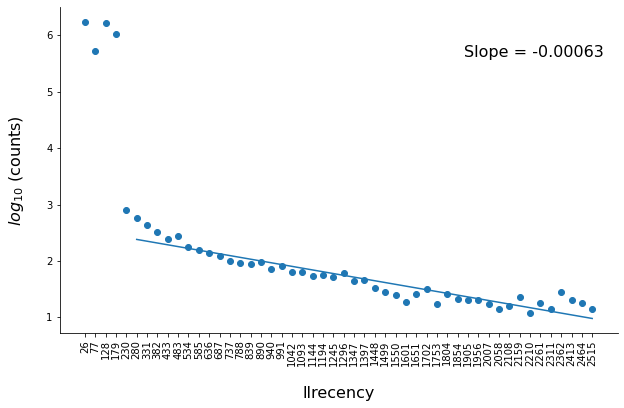

In [54]:
n_bins = 50
plot_log_scale(data_for_clustering, 'llrecency', n_bins, start_at = 5)

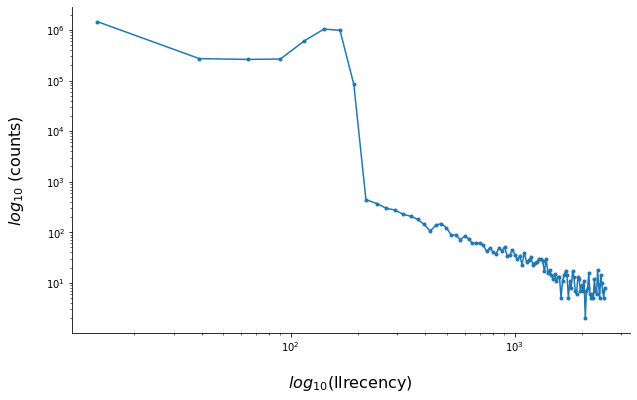

In [55]:
n_bins = 100
plot_loglog_scale(data_for_clustering, 'llrecency', n_bins)

The majority of users in this data set have a recency of up to 200 days or so. The decay in the counts of users with a longer recency seems to follow a power-law. Still need to think to try and understand why only the tail behaves like a power-law, while the larger group of recency < 200 is almost flat. 

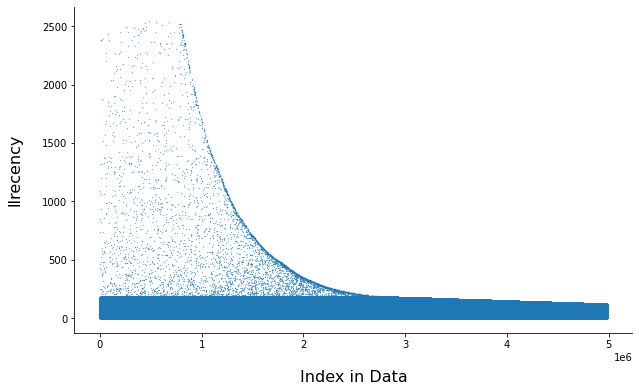

In [56]:
plot_data_by_index(data_for_clustering, 'llrecency')

Here it is easy to observe the dynamics of the installs in the app. The exponentialy decaying envelope most probably represent users that installed the app at more and more recent times, and stopped using the app shortly after installation. 
This graph also shows that the majority of users have recency of up to about 200 days (see also graphs above in this section), almost independently of when they installed the app. This suggest that users may have windows of up to about half a year without playing at the app, after which they still return to use it. 

[back to top](#back_to_top)  <a id='lifetime_revenue'></a>

#### Lifetime_Revenue_Net

In [57]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "Lifetime_Revenue_Net")

print("The net revenue of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest revenue is: {}\nThe highest revenue is: {}".format(min_value, max_value))

The net revenue of the users in this data set span 395460 different values.
The lowest revenue is: -2875.362
The highest revenue is: 410324.438


In [58]:
negative_revenue = len(data_for_clustering[data_for_clustering["Lifetime_Revenue_Net"] < 0])
print("There are {} users with *negative* life time revenue.".format(negative_revenue))

zero_revenue = len(data_for_clustering[data_for_clustering["Lifetime_Revenue_Net"] == 0])
print("\nThere are {} users with *zero* life time revenue.".format(zero_revenue))
print("This is {:.2f}% of the users in the list.".format(zero_revenue/len(data_for_clustering["Lifetime_Revenue_Net"])*100))

positive_revenue = len(data_for_clustering[data_for_clustering["Lifetime_Revenue_Net"] > 0])
below_50_revenue = len(data_for_clustering[(data_for_clustering["Lifetime_Revenue_Net"] > 0) & (data_for_clustering["Lifetime_Revenue_Net"] <= 50)])
below_1000_revenue = len(data_for_clustering[(data_for_clustering["Lifetime_Revenue_Net"] > 0) & (data_for_clustering["Lifetime_Revenue_Net"] <= 1000)])
print("\nThere are {} users with *positive* life time revenue,".format(positive_revenue))
print("of which {} (or {:.2f}% of the users) are users with less than *50* in revenue.".format(below_50_revenue, below_50_revenue/positive_revenue*100))
print("and {} (or {:.2f}% of the users) are users with less than *1000* in revenue.".format(below_1000_revenue, below_1000_revenue/positive_revenue*100))

There are 25 users with *negative* life time revenue.

There are 4190866 users with *zero* life time revenue.
This is 84.06% of the users in the list.

There are 794406 users with *positive* life time revenue,
of which 424356 (or 53.42% of the users) are users with less than *50* in revenue.
and 663064 (or 83.47% of the users) are users with less than *1000* in revenue.


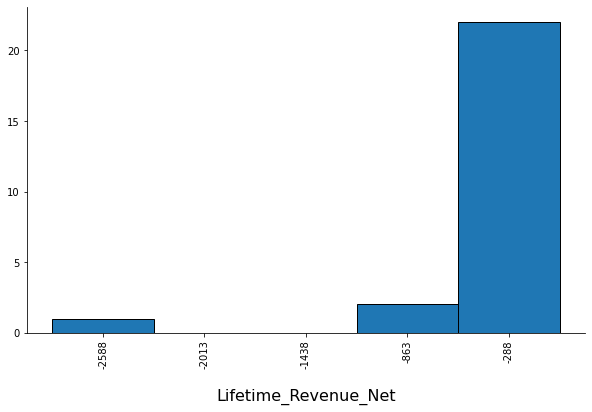

In [59]:
# Plotting the users with negative life-time revenue
n_bins = 5
adjusted_df = data_for_clustering.drop(data_for_clustering[data_for_clustering.Lifetime_Revenue_Net >= 0].index)
hist_of_numerical_feature(adjusted_df, 'Lifetime_Revenue_Net', n_bins)

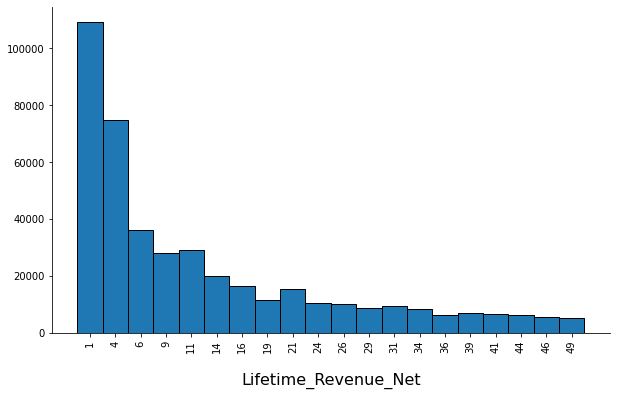

In [60]:
# Plotting the users with positive life-time revenue of below 50
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Lifetime_Revenue_Net <= 0) | (data_for_clustering.Lifetime_Revenue_Net >= 50)].index))
hist_of_numerical_feature(adjusted_df, 'Lifetime_Revenue_Net', n_bins)

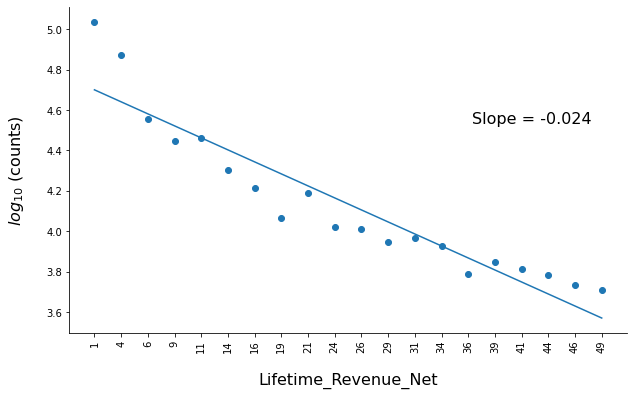

In [61]:
plot_log_scale(adjusted_df, 'Lifetime_Revenue_Net', n_bins)

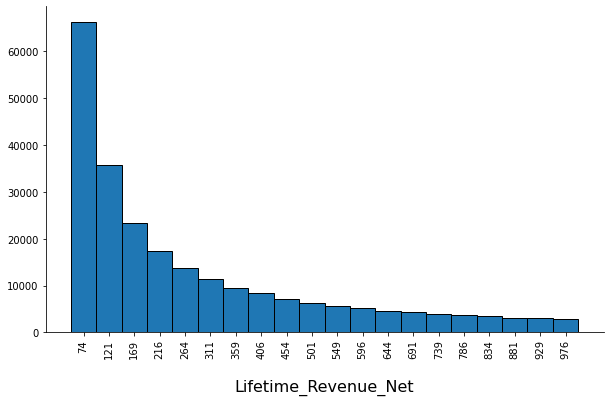

In [62]:
# Plotting the users with positive life-time revenue of above 50 and below 1000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Lifetime_Revenue_Net < 50) | (data_for_clustering.Lifetime_Revenue_Net >= 1000)].index))
hist_of_numerical_feature(adjusted_df, 'Lifetime_Revenue_Net', n_bins)

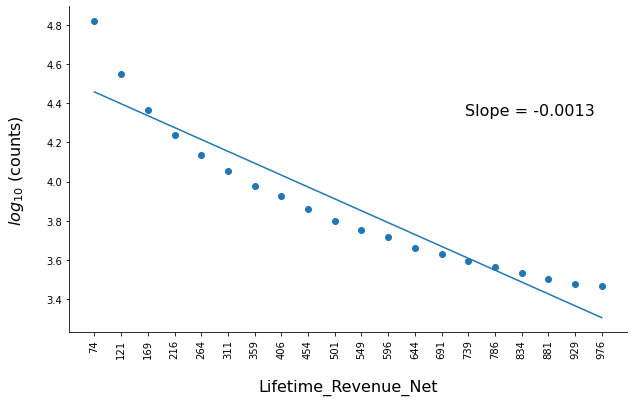

In [63]:
plot_log_scale(adjusted_df, 'Lifetime_Revenue_Net', n_bins)

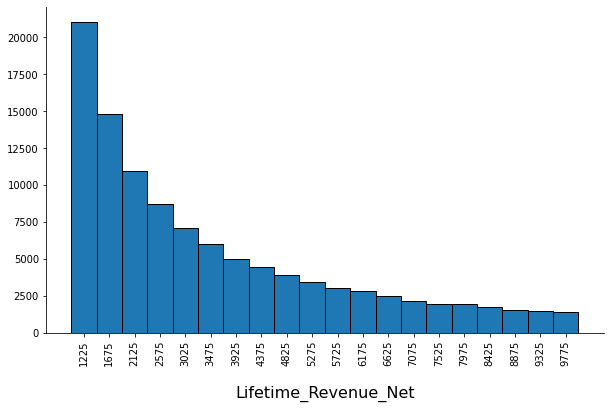

In [64]:
# Plotting the users with positive life-time revenue of above 1000 and below 10000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Lifetime_Revenue_Net < 1000) | (data_for_clustering.Lifetime_Revenue_Net >= 10000)].index))
hist_of_numerical_feature(adjusted_df, 'Lifetime_Revenue_Net', n_bins)

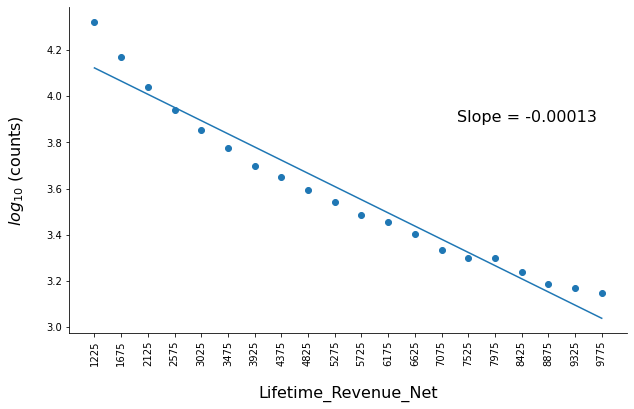

In [65]:
plot_log_scale(adjusted_df, 'Lifetime_Revenue_Net', n_bins)

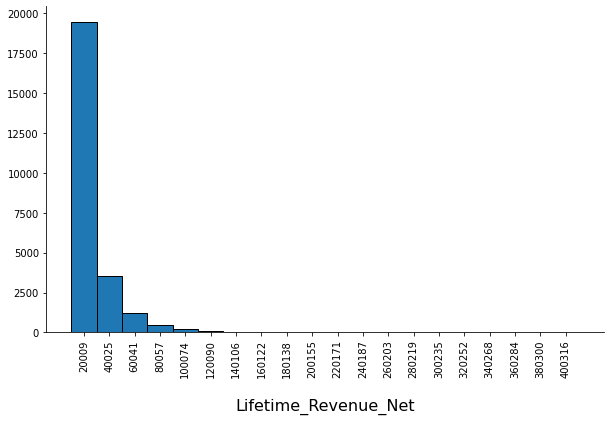

In [66]:
# Plotting the users with life-time revenue of above 10000
n_bins = 20
adjusted_df = data_for_clustering.drop(data_for_clustering[data_for_clustering.Lifetime_Revenue_Net < 10000].index)
hist_of_numerical_feature(adjusted_df, 'Lifetime_Revenue_Net', n_bins)

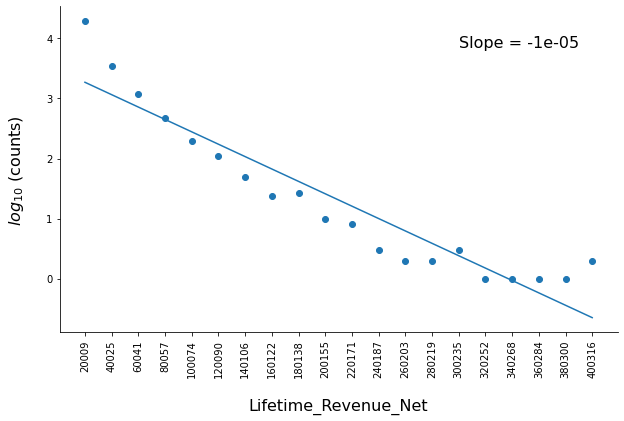

In [67]:
plot_log_scale(adjusted_df, 'Lifetime_Revenue_Net', n_bins)

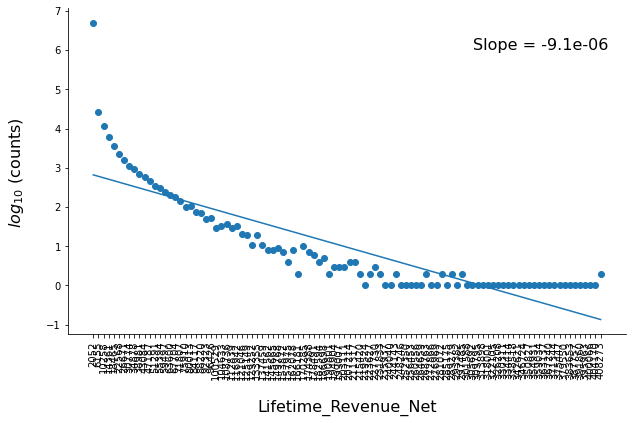

In [68]:
# Checking if the revenue follows an exponential distribution
n_bins = 100
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Lifetime_Revenue_Net < 0)].index))
plot_log_scale(adjusted_df, 'Lifetime_Revenue_Net', n_bins)

The fall in counts of users who pays more is much sharper than exponential over the complete range of possible revenues (from 0 revenue for the vast majority of the users, to the max value with single users). Same is observed for different ranges of the revenue (e.g., 0 < revenue < 50) as shown in figures above. 

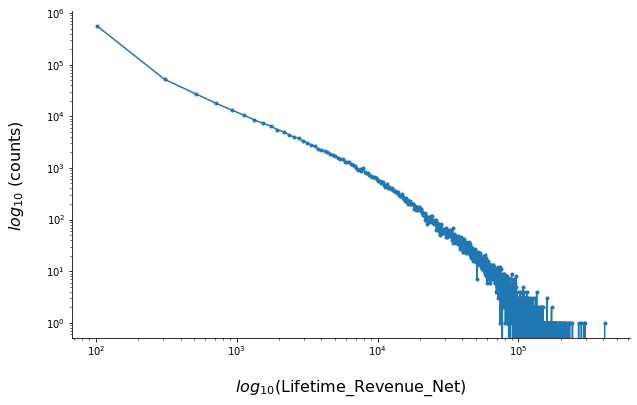

In [69]:
n_bins = 2000
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Lifetime_Revenue_Net <= 0)].index))

plot_loglog_scale(adjusted_df, 'Lifetime_Revenue_Net', n_bins)

Seems like the users who has a positive revenue follows a power-law distribution. If the non-zero revenue users are added, the 'kink' between the initial two data points is more pronounced, suggesting that there is a categorical difference between the paying and non-paying users. That is, they do not originate as part of the same distribution. 

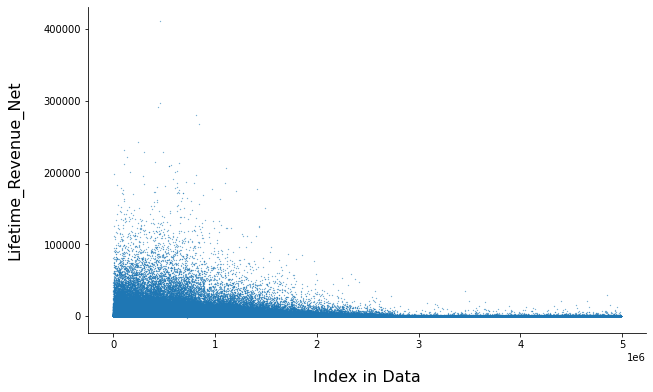

In [70]:
plot_data_by_index(data_for_clustering, 'Lifetime_Revenue_Net')

How much time a user spent on the app is correlated with the revenue they produce as can be seen in this graph. To remind, users with lower index have installed the app further back in time. 

[back to top](#back_to_top)  <a id='last30d_revenue'></a>

#### Last_30D_Revenue_Net

In [71]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "Last_30D_Revenue_Net")

print("The net revenue of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest revenue is: {}\nThe highest revenue is: {}".format(min_value, max_value))

The net revenue of the users in this data set span 98886 different values.
The lowest revenue is: -970.676
The highest revenue is: 20522.3819


In [72]:
negative_revenue = len(data_for_clustering[data_for_clustering["Last_30D_Revenue_Net"] < 0])
print("There are {} users with *negative* last 30 days revenue.".format(negative_revenue))

zero_revenue = len(data_for_clustering[data_for_clustering["Last_30D_Revenue_Net"] == 0])
print("\nThere are {} users with *zero* last 30 days revenue.".format(zero_revenue))
print("This is {:.2f}% of the users in the list.".format(zero_revenue/len(data_for_clustering["Last_30D_Revenue_Net"])*100))

positive_revenue = len(data_for_clustering[data_for_clustering["Last_30D_Revenue_Net"] > 0])
below_50_revenue = len(data_for_clustering[(data_for_clustering["Last_30D_Revenue_Net"] > 0) & (data_for_clustering["Last_30D_Revenue_Net"] <= 50)])
below_1000_revenue = len(data_for_clustering[(data_for_clustering["Last_30D_Revenue_Net"] > 0) & (data_for_clustering["Last_30D_Revenue_Net"] <= 1000)])
print("\nThere are {} users with *positive* last 30 days revenue,".format(positive_revenue))
print("of which {} (or {:.2f}% of the users) are users with less than *50* in revenue.".format(below_50_revenue, below_50_revenue/positive_revenue*100))
print("and {} (or {:.2f}% of the users) are users with less than *1000* in revenue.".format(below_1000_revenue, below_1000_revenue/positive_revenue*100))

There are 21 users with *negative* last 30 days revenue.

There are 4723048 users with *zero* last 30 days revenue.
This is 94.74% of the users in the list.

There are 262228 users with *positive* last 30 days revenue,
of which 172890 (or 65.93% of the users) are users with less than *50* in revenue.
and 254216 (or 96.94% of the users) are users with less than *1000* in revenue.


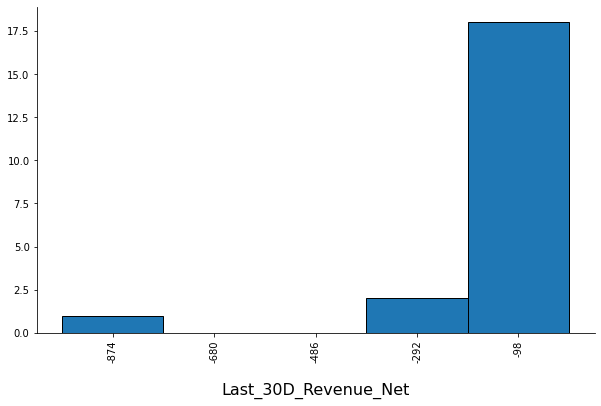

In [73]:
# Plotting the users with negative 30 days revenue
n_bins = 5
adjusted_df = data_for_clustering.drop(data_for_clustering[data_for_clustering.Last_30D_Revenue_Net >= 0].index)
hist_of_numerical_feature(adjusted_df, 'Last_30D_Revenue_Net', n_bins)

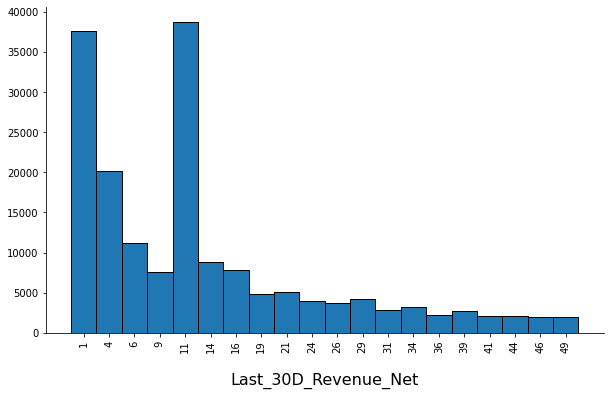

In [74]:
# Plotting the users with positive 30 days revenue of below 50
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_30D_Revenue_Net <= 0) | (data_for_clustering.Last_30D_Revenue_Net >= 50)].index))
hist_of_numerical_feature(adjusted_df, 'Last_30D_Revenue_Net', n_bins)

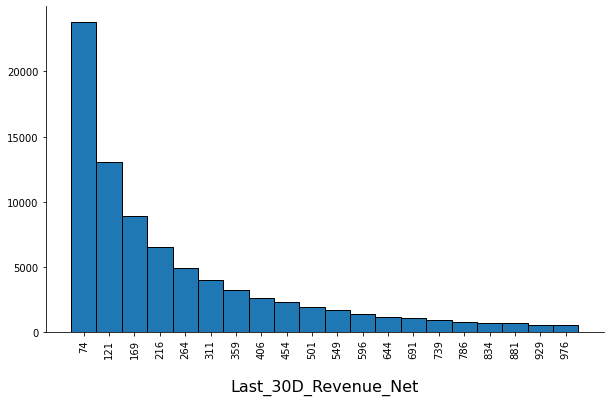

In [75]:
# Plotting the users with positive 30 days revenue of above 50 and below 1000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_30D_Revenue_Net < 50) | (data_for_clustering.Last_30D_Revenue_Net >= 1000)].index))
hist_of_numerical_feature(adjusted_df, 'Last_30D_Revenue_Net', n_bins)

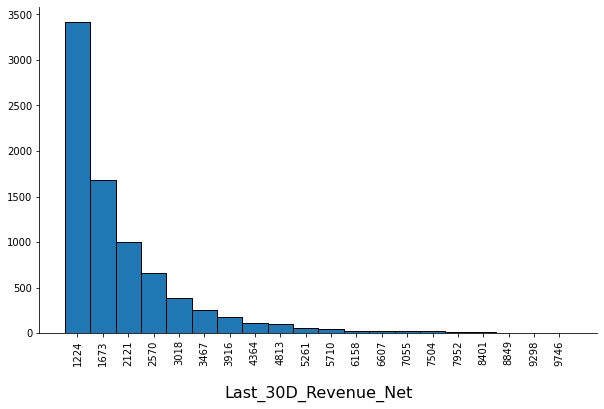

In [76]:
# Plotting the users with positive 30 days revenue of above 1000 and below 10000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_30D_Revenue_Net < 1000) | (data_for_clustering.Last_30D_Revenue_Net >= 10000)].index))
hist_of_numerical_feature(adjusted_df, 'Last_30D_Revenue_Net', n_bins)

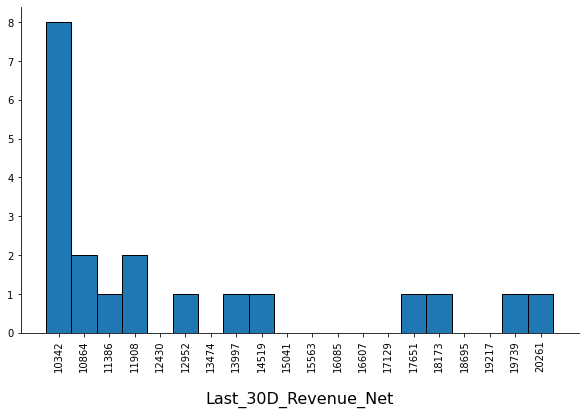

In [77]:
# Plotting the users with 30 days revenue of above 10000
n_bins = 20
adjusted_df = data_for_clustering.drop(data_for_clustering[data_for_clustering.Last_30D_Revenue_Net < 10000].index)
hist_of_numerical_feature(adjusted_df, 'Last_30D_Revenue_Net', n_bins)

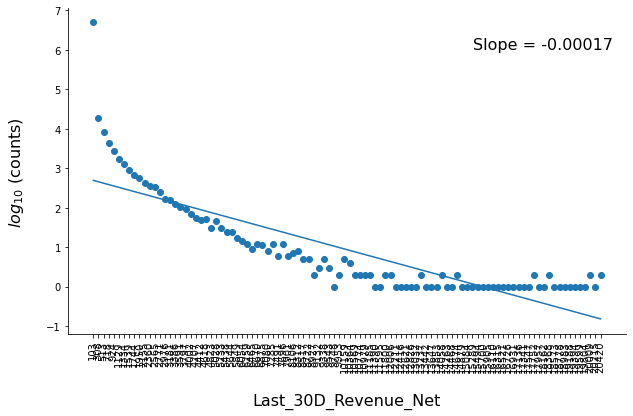

In [78]:
# Checking if the revenue follows an exponential distribution
n_bins = 100
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_30D_Revenue_Net < 0)].index))
plot_log_scale(adjusted_df, 'Last_30D_Revenue_Net', n_bins)

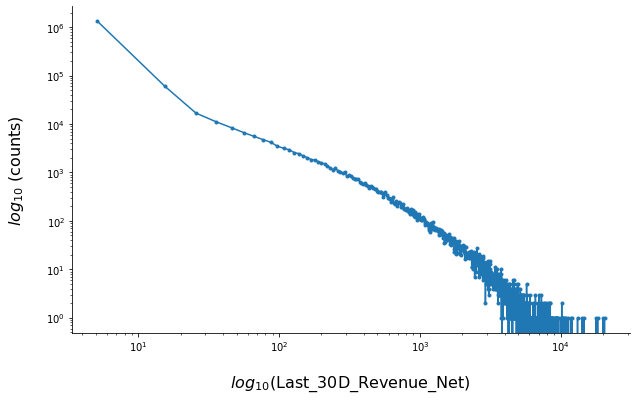

In [79]:
n_bins = 2000
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.llrecency >30)].index))
adjusted_df = adjusted_df.drop((adjusted_df[(adjusted_df.Last_30D_Revenue_Net < 0)].index))

plot_loglog_scale(adjusted_df, 'Last_30D_Revenue_Net', n_bins)

With the non-paying users - an obvious kink at the beginning. 

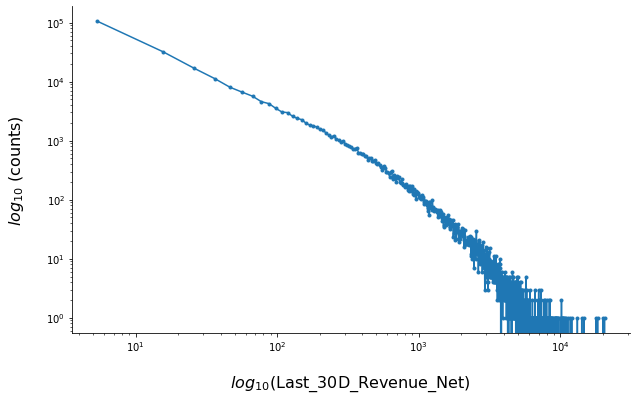

In [80]:
n_bins = 2000
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.llrecency >30)].index))
adjusted_df = adjusted_df.drop((adjusted_df[(adjusted_df.Last_30D_Revenue_Net <= 0)].index))

plot_loglog_scale(adjusted_df, 'Last_30D_Revenue_Net', n_bins)

Only the paying users - a beautiful power-law relation. The above figures suggests that there is a distinction between the paying and non-paying groups of users who contributed at the Last 30 Days users. 

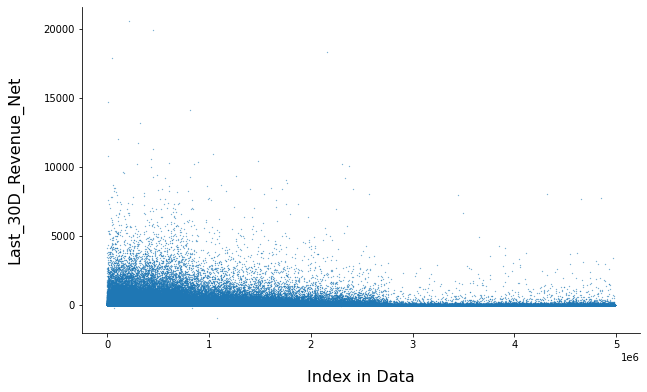

In [81]:
plot_data_by_index(data_for_clustering, 'Last_30D_Revenue_Net')

The longer a user has been on the app, the higher the probability they will spend more money on the app in the last 30 days. 

[back to top](#back_to_top)  <a id='last90d_revenue'></a>

#### Last_90D_Revenue_Net

In [82]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "Last_90D_Revenue_Net")

print("The net revenue of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest revenue is: {}\nThe highest revenue is: {}".format(min_value, max_value))

The net revenue of the users in this data set span 161141 different values.
The lowest revenue is: -1071.6552
The highest revenue is: 48765.5232


In [83]:
negative_revenue = len(data_for_clustering[data_for_clustering["Last_90D_Revenue_Net"] < 0])
print("There are {} users with *negative* last 90 days revenue.".format(negative_revenue))

zero_revenue = len(data_for_clustering[data_for_clustering["Last_90D_Revenue_Net"] == 0])
print("\nThere are {} users with *zero* last 90 days revenue.".format(zero_revenue))
print("This is {:.2f}% of the users in the list.".format(zero_revenue/len(data_for_clustering["Last_90D_Revenue_Net"])*100))

positive_revenue = len(data_for_clustering[data_for_clustering["Last_90D_Revenue_Net"] > 0])
below_50_revenue = len(data_for_clustering[(data_for_clustering["Last_90D_Revenue_Net"] > 0) & (data_for_clustering["Last_90D_Revenue_Net"] <= 50)])
below_1000_revenue = len(data_for_clustering[(data_for_clustering["Last_90D_Revenue_Net"] > 0) & (data_for_clustering["Last_90D_Revenue_Net"] <= 1000)])
print("\nThere are {} users with *positive* last 90 days revenue,".format(positive_revenue))
print("of which {} (or {:.2f}% of the users) are users with less than *50* in revenue.".format(below_50_revenue, below_50_revenue/positive_revenue*100))
print("and {} (or {:.2f}% of the users) are users with less than *1000* in revenue.".format(below_1000_revenue, below_1000_revenue/positive_revenue*100))

There are 28 users with *negative* last 90 days revenue.

There are 4619599 users with *zero* last 90 days revenue.
This is 92.66% of the users in the list.

There are 365670 users with *positive* last 90 days revenue,
of which 219057 (or 59.91% of the users) are users with less than *50* in revenue.
and 337326 (or 92.25% of the users) are users with less than *1000* in revenue.


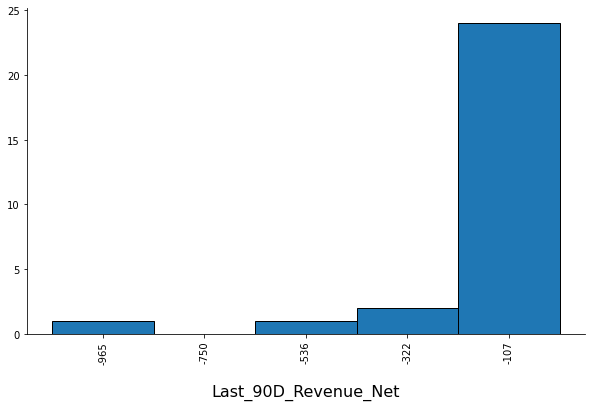

In [84]:
# Plotting the users with negative 90 days revenue
n_bins = 5
adjusted_df = data_for_clustering.drop(data_for_clustering[data_for_clustering.Last_90D_Revenue_Net >= 0].index)
hist_of_numerical_feature(adjusted_df, 'Last_90D_Revenue_Net', n_bins)

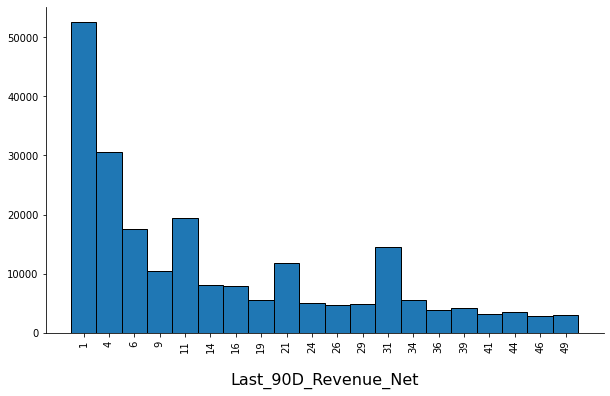

In [85]:
# Plotting the users with positive 90 days revenue of below 50
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_90D_Revenue_Net <= 0) | (data_for_clustering.Last_90D_Revenue_Net >= 50)].index))
hist_of_numerical_feature(adjusted_df, 'Last_90D_Revenue_Net', n_bins)

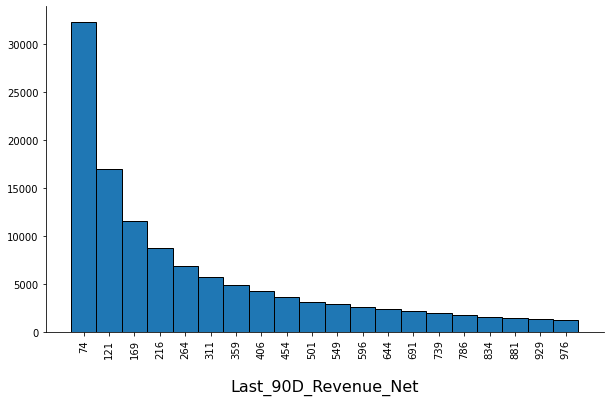

In [86]:
# Plotting the users with positive 90 days revenue of above 50 and below 1000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_90D_Revenue_Net < 50) | (data_for_clustering.Last_90D_Revenue_Net >= 1000)].index))
hist_of_numerical_feature(adjusted_df, 'Last_90D_Revenue_Net', n_bins)

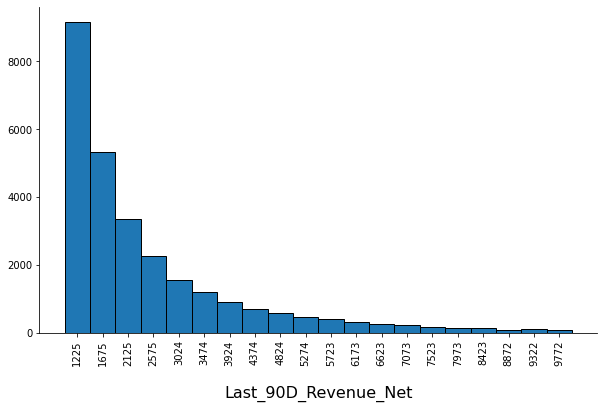

In [87]:
# Plotting the users with positive 90 days revenue of above 1000 and below 10000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_90D_Revenue_Net < 1000) | (data_for_clustering.Last_90D_Revenue_Net >= 10000)].index))
hist_of_numerical_feature(adjusted_df, 'Last_90D_Revenue_Net', n_bins)

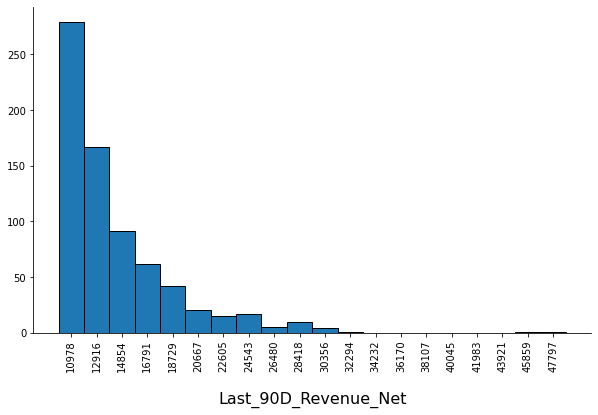

In [88]:
# Plotting the users with 90 days revenue of above 10000
n_bins = 20
adjusted_df = data_for_clustering.drop(data_for_clustering[data_for_clustering.Last_90D_Revenue_Net < 10000].index)
hist_of_numerical_feature(adjusted_df, 'Last_90D_Revenue_Net', n_bins)

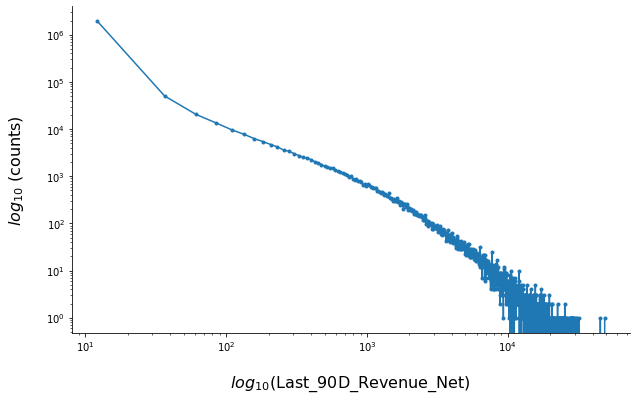

In [89]:
n_bins = 2000
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.llrecency >90)].index))
adjusted_df = adjusted_df.drop((adjusted_df[(adjusted_df.Last_90D_Revenue_Net < 0)].index))

plot_loglog_scale(adjusted_df, 'Last_90D_Revenue_Net', n_bins)

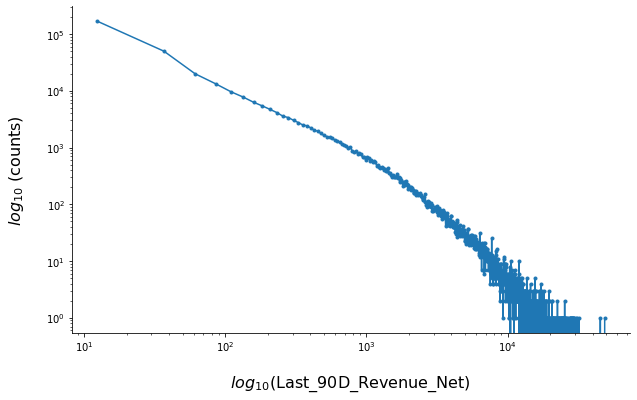

In [90]:
n_bins = 2000
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.llrecency > 90)].index))
adjusted_df = adjusted_df.drop((adjusted_df[(adjusted_df.Last_90D_Revenue_Net <= 0)].index))

plot_loglog_scale(adjusted_df, 'Last_90D_Revenue_Net', n_bins)

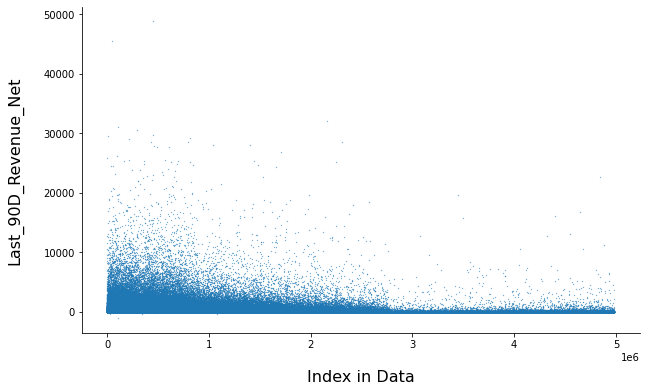

In [91]:
plot_data_by_index(data_for_clustering, 'Last_90D_Revenue_Net')

The longer a user has been on the app, the higher the probability they will spend more money on the app in the last 90 days. 

[back to top](#back_to_top)  <a id='last30d_transactions'></a>

#### Last_30D_Transactions

In [92]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "Last_30D_Transactions")

print("The number of transactions in the last 30 days of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest number of transactions is: {}\nThe highest is: {}".format(min_value, max_value))

The number of transactions in the last 30 days of the users in this data set span 31 different values.
The lowest number of transactions is: 0
The highest is: 30


In [93]:
zero_transactions = len(data_for_clustering[data_for_clustering["Last_30D_Transactions"] == 0])
print("\nThere are {} users with *zero* last 30 days transactions.".format(zero_transactions))
print("This is {:.2f}% of the users in the list.".format(zero_transactions/len(data_for_clustering["Last_30D_Transactions"])*100))


There are 4723046 users with *zero* last 30 days transactions.
This is 94.74% of the users in the list.


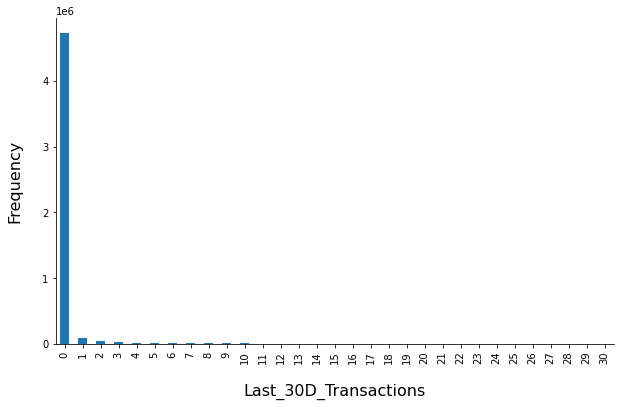

In [94]:
bar_plot_of_feature(data_for_clustering, 'Last_30D_Transactions')

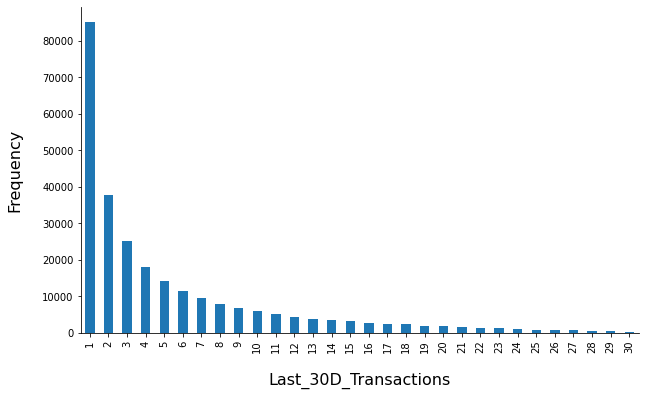

In [95]:
# Plotting the distribution of the users that did at least a single transaction
adjusted_df = data_for_clustering.drop((data_for_clustering[data_for_clustering.Last_30D_Transactions == 0].index))
bar_plot_of_feature(adjusted_df, 'Last_30D_Transactions')

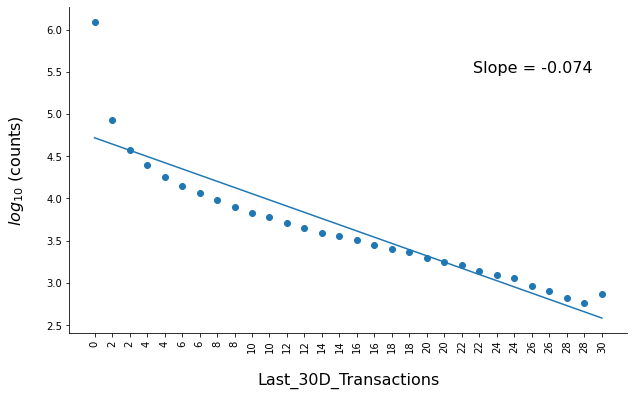

In [96]:
# Checking if the revenue follows an exponential distribution
n_bins = 30
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.llrecency > 30)].index))
# adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_30D_Transactions == 0)].index))
plot_log_scale(adjusted_df, 'Last_30D_Transactions', n_bins)

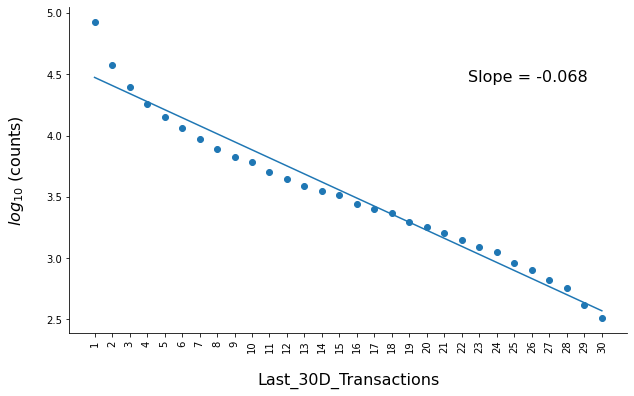

In [97]:
# Checking if the transactions follows an exponential distribution
n_bins = 30
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.llrecency > 30)].index))
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_30D_Transactions == 0)].index))
plot_log_scale(adjusted_df, 'Last_30D_Transactions', n_bins)

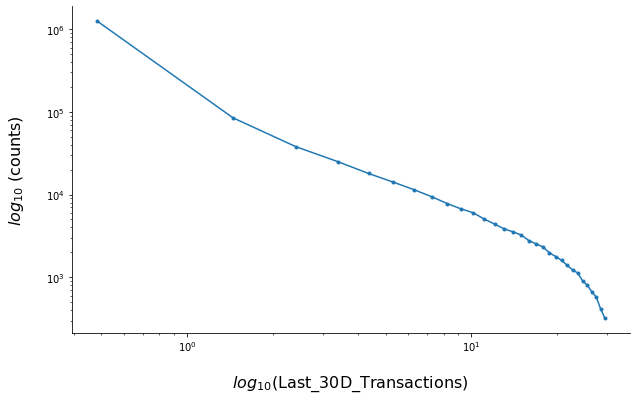

In [98]:
n_bins = 31
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.llrecency > 30)].index))

plot_loglog_scale(adjusted_df, 'Last_30D_Transactions', n_bins)

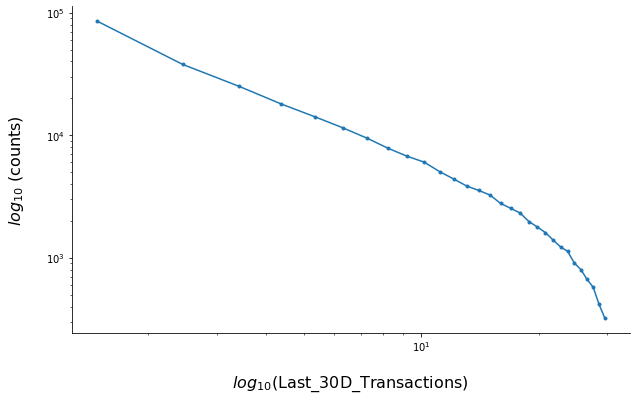

In [99]:
n_bins = 30
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.llrecency > 30)].index))
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_30D_Transactions == 0)].index))

plot_loglog_scale(adjusted_df, 'Last_30D_Transactions', n_bins)

Here as well, the zero-transactions users don't follow the same power-law distribution as the users who had positive number of transactions. Logically following the last-30days revenue results. 

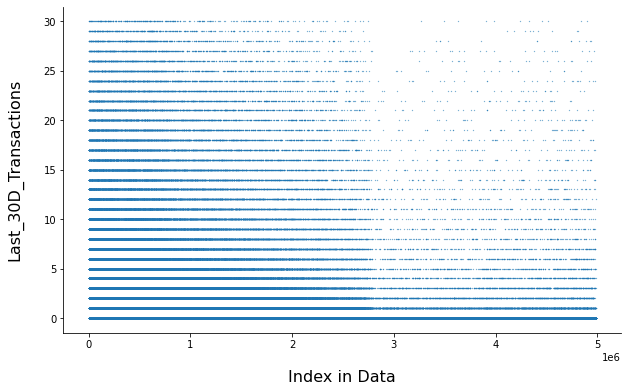

In [100]:
plot_data_by_index(data_for_clustering, 'Last_30D_Transactions')

The longer a user was on the app (lower index value) the higher the probability they had more transactions in the last 30 days. 

[back to top](#back_to_top)  <a id='sink'></a>

#### Last_30D_Gross_Sink

In [101]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "Last_30D_Gross_Sink")

print("The gross sink in the last 30 days of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest sink is: {}\nThe highest is: {}".format(min_value, max_value))

The gross sink in the last 30 days of the users in this data set span 131464 different values.
The lowest sink is: 0.0
The highest is: 8902380.0


In [102]:
zero_sink = len(data_for_clustering[data_for_clustering["Last_30D_Gross_Sink"] == 0])
print("\nThere are {} users with *zero* last 30 days sink.".format(zero_sink))
print("This is {:.2f}% of the users in the list.".format(zero_sink/len(data_for_clustering["Last_30D_Gross_Sink"])*100))


There are 3667571 users with *zero* last 30 days sink.
This is 73.57% of the users in the list.


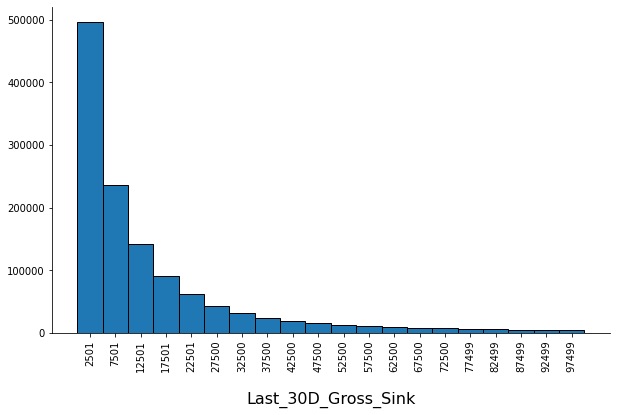

In [103]:
# Plotting the users with positive sink of below 100000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_30D_Gross_Sink <= 0) | (data_for_clustering.Last_30D_Gross_Sink >= 100000)].index))
hist_of_numerical_feature(adjusted_df, 'Last_30D_Gross_Sink', n_bins)

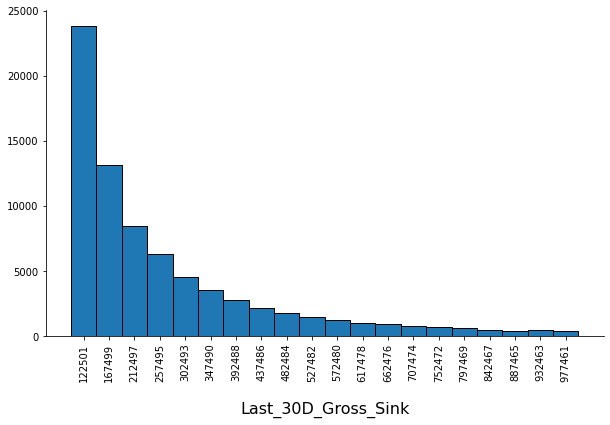

In [104]:
# Plotting the users with positive sink of above 100000 and below 1000000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_30D_Gross_Sink <= 100000) | (data_for_clustering.Last_30D_Gross_Sink >= 1000000)].index))
hist_of_numerical_feature(adjusted_df, 'Last_30D_Gross_Sink', n_bins)

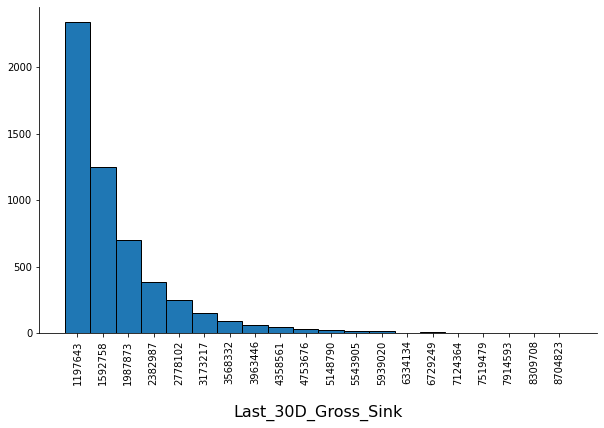

In [105]:
# Plotting the users with positive sink of above 1000000 
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_30D_Gross_Sink <= 1000000)].index))
hist_of_numerical_feature(adjusted_df, 'Last_30D_Gross_Sink', n_bins)

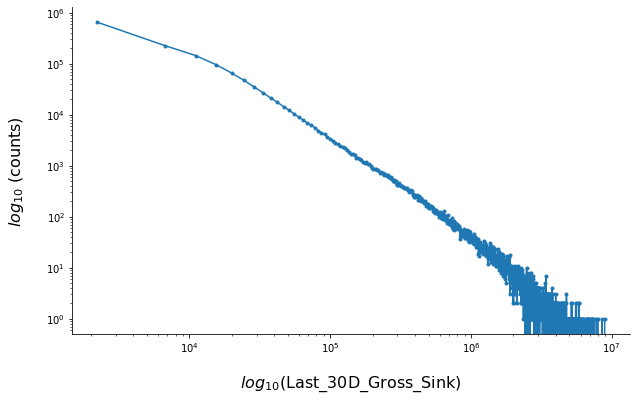

In [106]:
n_bins = 2000
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.llrecency > 30)].index))

plot_loglog_scale(adjusted_df, 'Last_30D_Gross_Sink', n_bins)

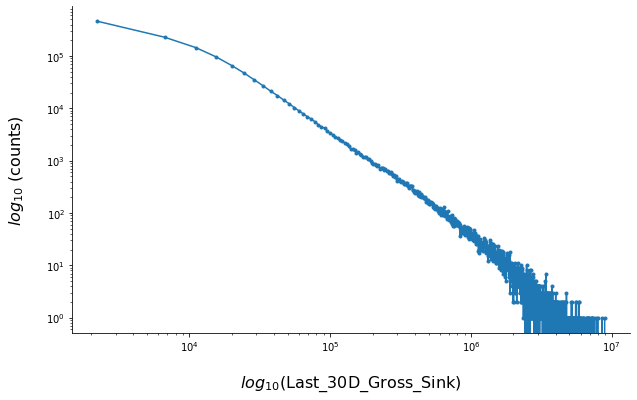

In [107]:
n_bins = 2000
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.llrecency > 30)].index))
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_30D_Gross_Sink == 0)].index))

plot_loglog_scale(adjusted_df, 'Last_30D_Gross_Sink', n_bins)

Seems like the gross sink behaves very similar to a power-law, with somewhat different powers for users with lower sink ( < 10^4) compared to users with higher sink.   
Both here and above for the revenue, I think that the power-law emerge from the proportionality of the required revenue or eventual sink: the more a user play, the higher will be their level, and the higher their sink and the higher the revenue they will need to invest in order to advance or just play the game.

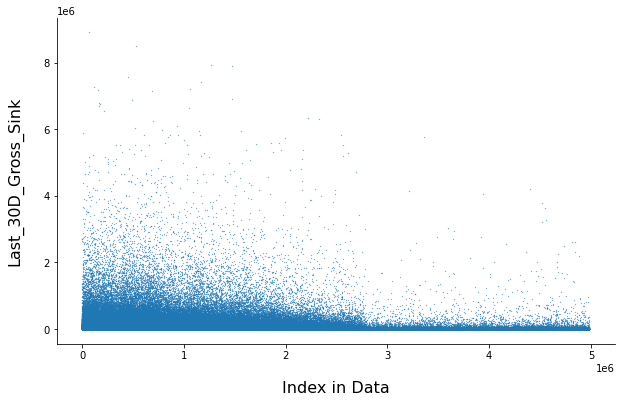

In [108]:
plot_data_by_index(data_for_clustering, 'Last_30D_Gross_Sink')

#### Last_90D_Gross_Sink

In [109]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "Last_90D_Gross_Sink")

print("The gross sink in the last 90 days of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest sink is: {}\nThe highest is: {}".format(min_value, max_value))

The gross sink in the last 90 days of the users in this data set span 251187 different values.
The lowest sink is: 0.0
The highest is: 24284899.0


In [110]:
zero_sink = len(data_for_clustering[data_for_clustering["Last_90D_Gross_Sink"] == 0])
print("\nThere are {} users with *zero* last 90 days sink.".format(zero_sink))
print("This is {:.2f}% of the users in the list.".format(zero_sink/len(data_for_clustering["Last_90D_Gross_Sink"])*100))


There are 3161994 users with *zero* last 90 days sink.
This is 63.43% of the users in the list.


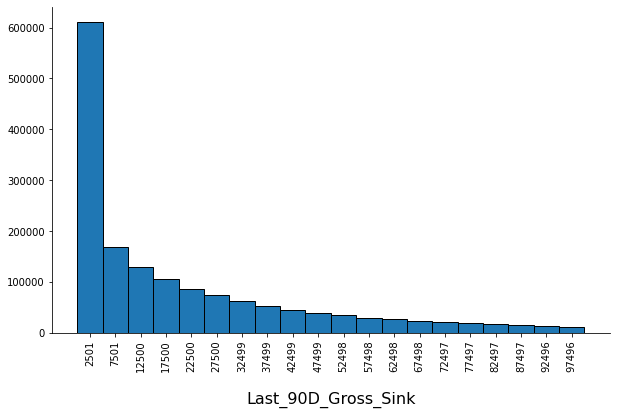

In [111]:
# Plotting the users with positive sink of below 100000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_90D_Gross_Sink <= 0) | (data_for_clustering.Last_90D_Gross_Sink >= 100000)].index))
hist_of_numerical_feature(adjusted_df, 'Last_90D_Gross_Sink', n_bins)

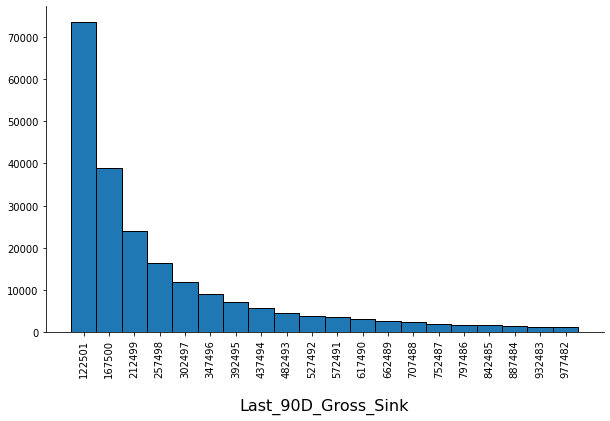

In [112]:
# Plotting the users with positive sink of above 100000 and below 1000000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_90D_Gross_Sink <= 100000) | (data_for_clustering.Last_90D_Gross_Sink >= 1000000)].index))
hist_of_numerical_feature(adjusted_df, 'Last_90D_Gross_Sink', n_bins)

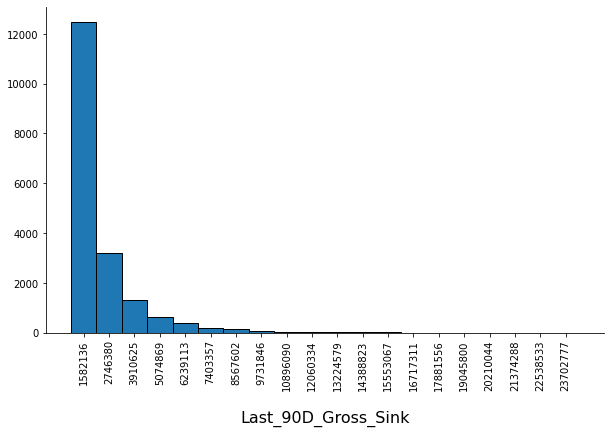

In [113]:
# Plotting the users with positive sink of above 1000000 
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_90D_Gross_Sink <= 1000000)].index))
hist_of_numerical_feature(adjusted_df, 'Last_90D_Gross_Sink', n_bins)

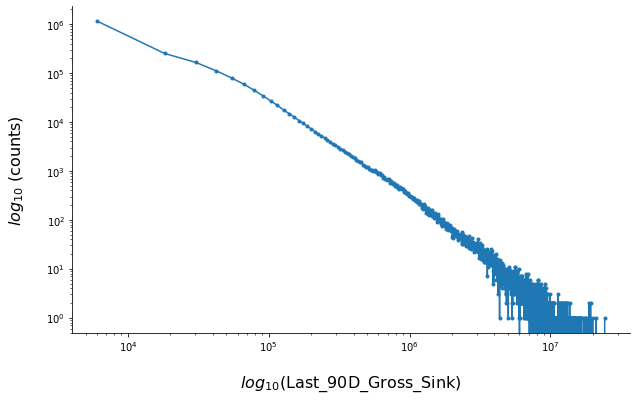

In [114]:
n_bins = 2000
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.llrecency > 90)].index))

plot_loglog_scale(adjusted_df, 'Last_90D_Gross_Sink', n_bins)

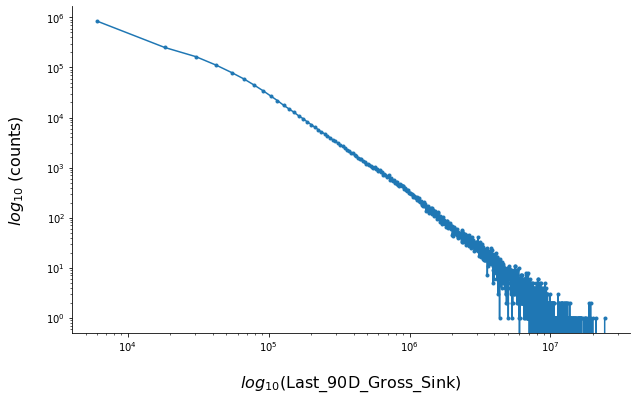

In [115]:
n_bins = 2000
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.llrecency > 90)].index))
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Last_90D_Gross_Sink == 0)].index))

plot_loglog_scale(adjusted_df, 'Last_90D_Gross_Sink', n_bins)

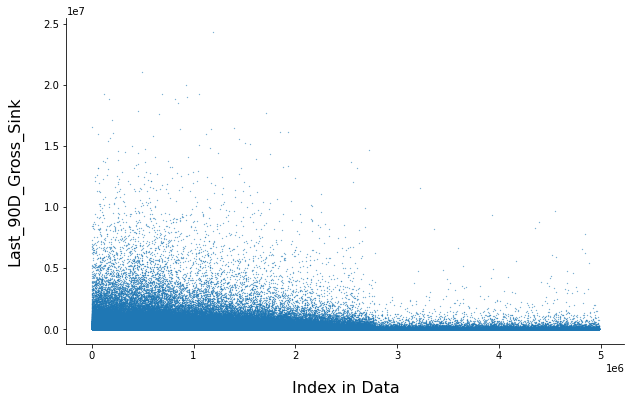

In [116]:
plot_data_by_index(data_for_clustering, 'Last_90D_Gross_Sink')

[back to top](#back_to_top)  <a id='login_days'></a>

#### Last_30D_Login_days

In [117]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "Last_30D_Login_days")

print("The number of login-days in the last 30 days of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest number of login-days is: {}\nThe is: {}".format(min_value, max_value))

The number of login-days in the last 30 days of the users in this data set span 31 different values.
The lowest number of login-days is: 0
The is: 30


In [118]:
zero_logindays = len(data_for_clustering[data_for_clustering["Last_30D_Login_days"] == 0])
print("\nThere are {} users with *zero* last 30 days login-days.".format(zero_logindays))
print("This is {:.2f}% of the users in the list.".format(zero_logindays/len(data_for_clustering["Last_30D_Login_days"])*100))


There are 3482986 users with *zero* last 30 days login-days.
This is 69.87% of the users in the list.


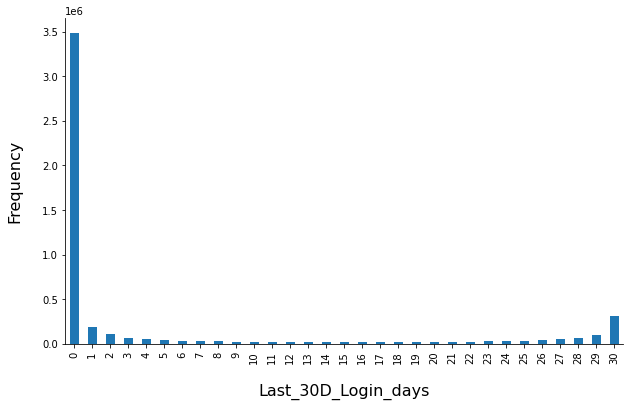

In [119]:
sorted_days = [days for days in range(31)]
bar_plot_of_feature(data_for_clustering, 'Last_30D_Login_days', x_labels_sorted = sorted_days)

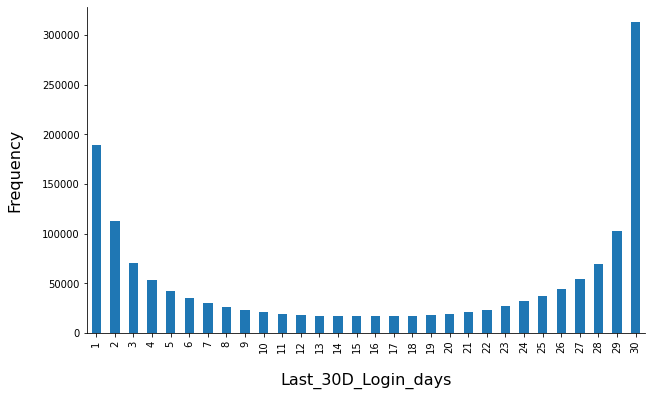

In [120]:
# Plotting the distribution of the users that had at least a single login
adjusted_df = data_for_clustering.drop((data_for_clustering[data_for_clustering.Last_30D_Login_days == 0].index))
sorted_days = [days for days in range(1,31)]
bar_plot_of_feature(adjusted_df, 'Last_30D_Login_days', x_labels_sorted = sorted_days)

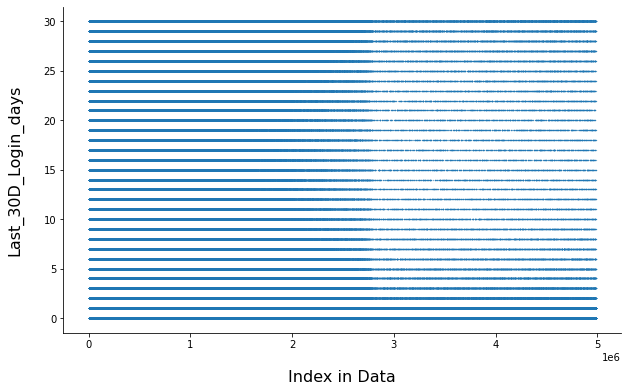

In [121]:
plot_data_by_index(data_for_clustering, 'Last_30D_Login_days')

#### Last_90D_Login_days

In [122]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "Last_90D_Login_days")

print("The number of login-days in the last 90 days of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest number of login-days is: {}\nThe highest is: {}".format(min_value, max_value))

The number of login-days in the last 90 days of the users in this data set span 91 different values.
The lowest number of login-days is: 0
The highest is: 90


In [123]:
zero_logindays = len(data_for_clustering[data_for_clustering["Last_90D_Login_days"] == 0])
print("\nThere are {} users with *zero* last 90 days login-days.".format(zero_logindays))
print("This is {:.2f}% of the users in the list.".format(zero_logindays/len(data_for_clustering["Last_90D_Login_days"])*100))


There are 2865639 users with *zero* last 90 days login-days.
This is 57.48% of the users in the list.


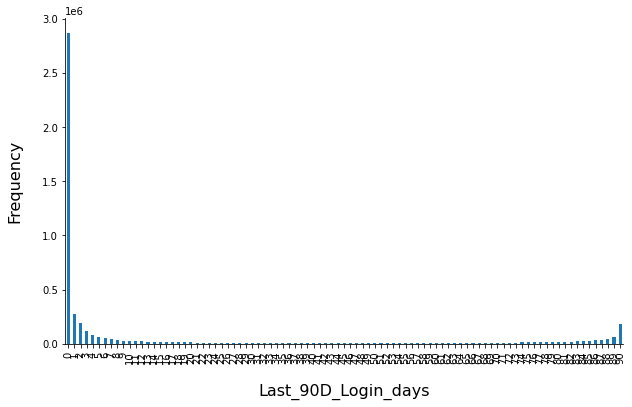

In [124]:
sorted_days = [days for days in range(91)]
bar_plot_of_feature(data_for_clustering, 'Last_90D_Login_days', x_labels_sorted = sorted_days)

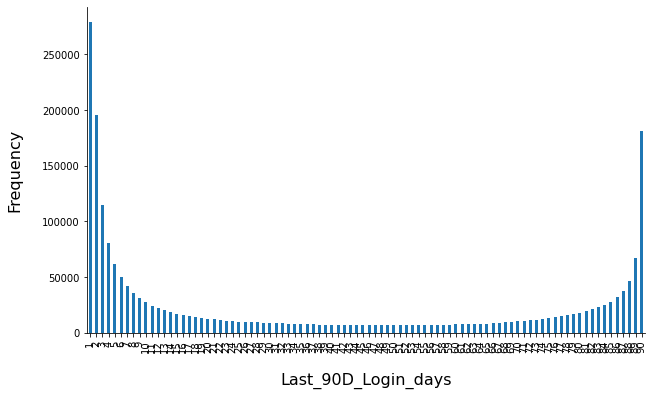

In [125]:
# Plotting the distribution of the users that had at least a single login
adjusted_df = data_for_clustering.drop((data_for_clustering[data_for_clustering.Last_90D_Login_days == 0].index))
sorted_days = [days for days in range(1,91)]
bar_plot_of_feature(adjusted_df, 'Last_90D_Login_days', x_labels_sorted = sorted_days)

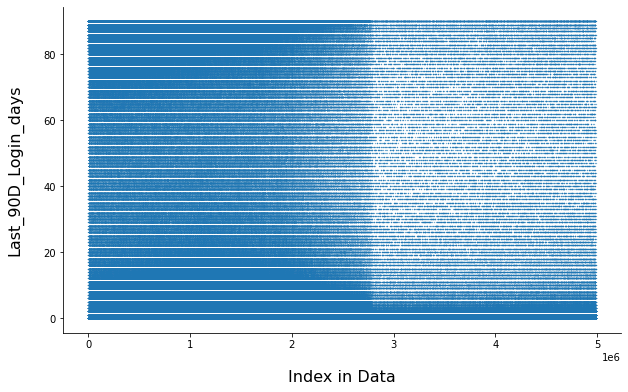

In [126]:
plot_data_by_index(data_for_clustering, 'Last_90D_Login_days')

#### Life_Time_Login_Days

In [127]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "Life_Time_Login_Days")

print("The number of login days of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest number of days is: {}\nThe highest is: {}".format(min_value, max_value))

The number of login days of the users in this data set span 3489 different values.
The lowest number of days is: 1
The highest is: 3628


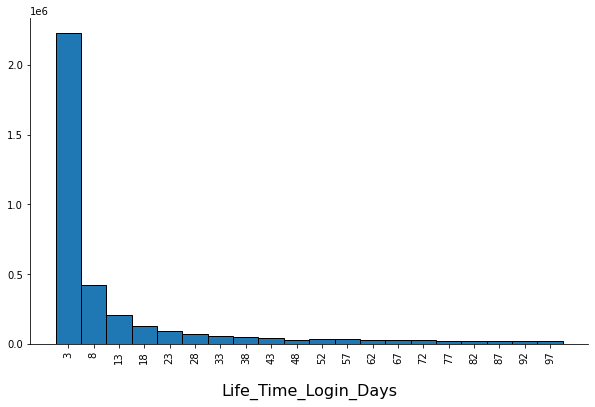

In [128]:
# Plotting the users with login days of below 100
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Life_Time_Login_Days >= 100)].index))
hist_of_numerical_feature(adjusted_df, 'Life_Time_Login_Days', n_bins)

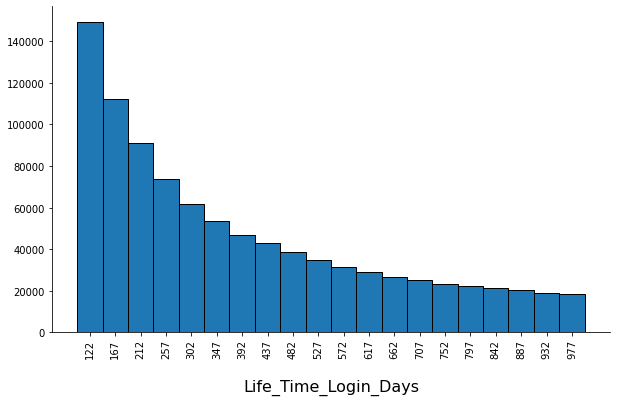

In [129]:
# Plotting the users with login days of above 100 and below 1000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Life_Time_Login_Days < 100) | (data_for_clustering.Life_Time_Login_Days >= 1000)].index))
hist_of_numerical_feature(adjusted_df, 'Life_Time_Login_Days', n_bins)

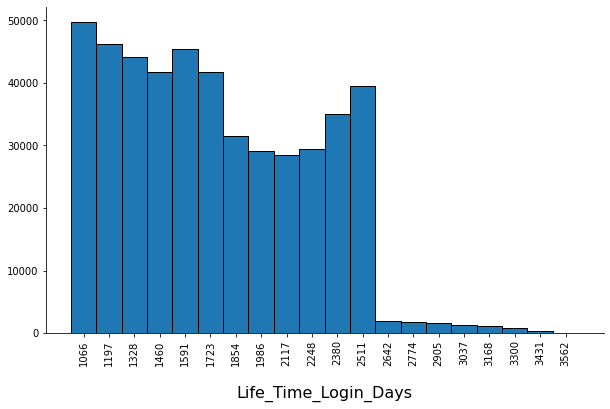

In [130]:
# Plotting the users with login days of above 1000 
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Life_Time_Login_Days < 1000)].index))
hist_of_numerical_feature(adjusted_df, 'Life_Time_Login_Days', n_bins)

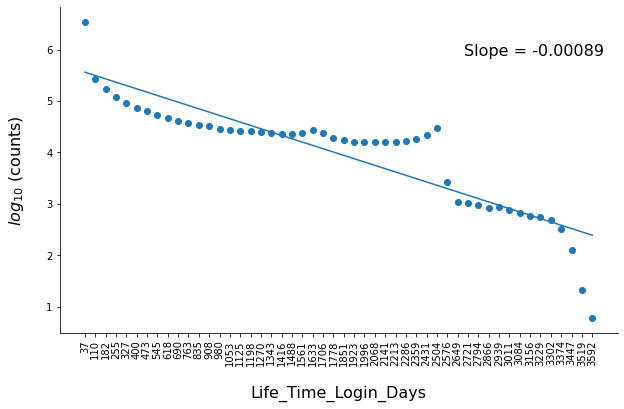

In [131]:
# Checking if the login-days follows an exponential distribution
n_bins = 50

# adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.Life_Time_Login_Days == 0)].index))
# plot_log_scale(adjusted_df, 'Life_Time_Login_Days', n_bins)

plot_log_scale(data_for_clustering, 'Life_Time_Login_Days', n_bins)

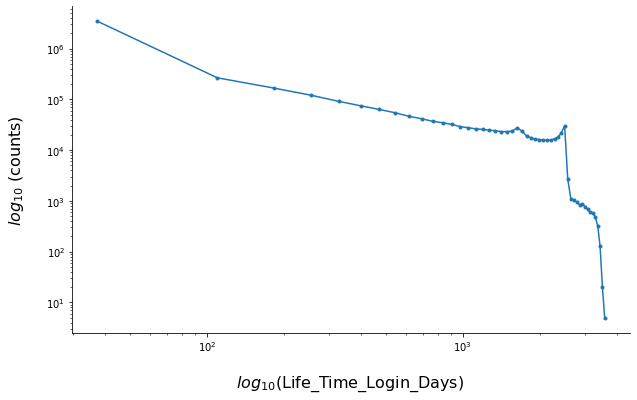

In [132]:
n_bins = 50

plot_loglog_scale(data_for_clustering, 'Life_Time_Login_Days', n_bins)

Seems like there are two groups here: users that have up to 2000 or so login days follow one power-law, and users with higher than 2500 login-days follow a sharper decrease. 

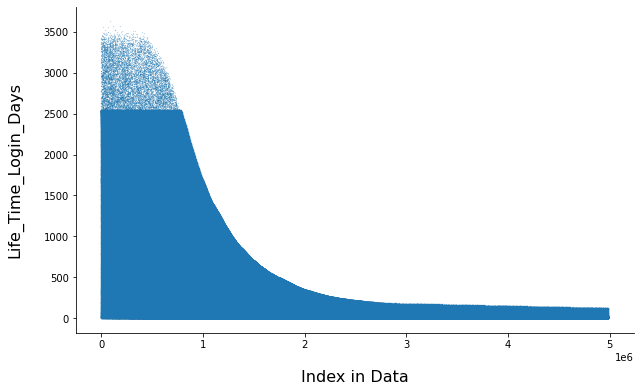

In [133]:
plot_data_by_index(data_for_clustering, 'Life_Time_Login_Days', marker_size = 0.2 )

The possible life-time login days are higher for users with a longer time on the app.    
It is not clear why the density of points changes at around the 2500 mark. 

[back to top](#back_to_top)  <a id='credit_eod'></a>

#### credits_balance_EOD

In [134]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "credits_balance_EOD")

print("The number of credits balance of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest number of credits is: {}\nThe highest is: {}".format(min_value, max_value))

The number of credits balance of the users in this data set span 58895 different values.
The lowest number of credits is: 0.0
The highest is: 15173803.0


In [135]:
zero_balance = len(data_for_clustering[data_for_clustering["credits_balance_EOD"] == 0])
print("\nThere are {} users with *zero* credits balance at end of day.".format(zero_balance))
print("This is {:.2f}% of the users in the list.".format(zero_balance/len(data_for_clustering["credits_balance_EOD"])*100))


There are 34954 users with *zero* credits balance at end of day.
This is 0.70% of the users in the list.


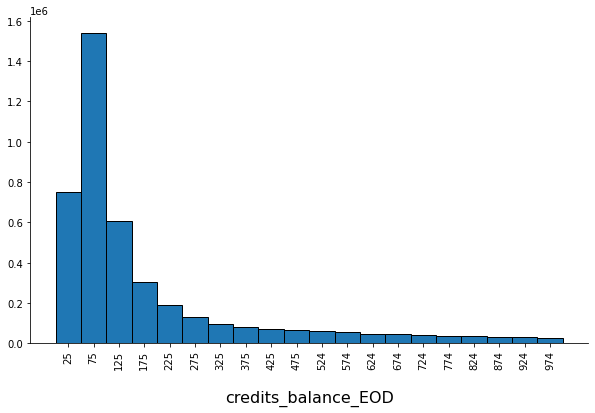

In [136]:
# Plotting the users with credit balance of below 1000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.credits_balance_EOD < 0) | (data_for_clustering.credits_balance_EOD >= 1000)].index))
hist_of_numerical_feature(adjusted_df, 'credits_balance_EOD', n_bins)

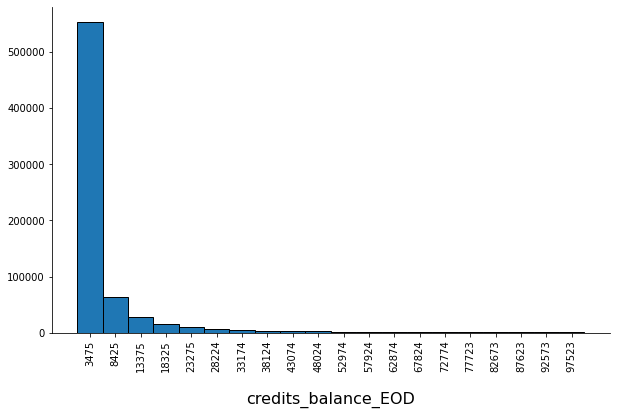

In [137]:
# Plotting the users with credit balance of above 1000 and below 100000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.credits_balance_EOD < 1000) | (data_for_clustering.credits_balance_EOD >= 100000)].index))
hist_of_numerical_feature(adjusted_df, 'credits_balance_EOD', n_bins)

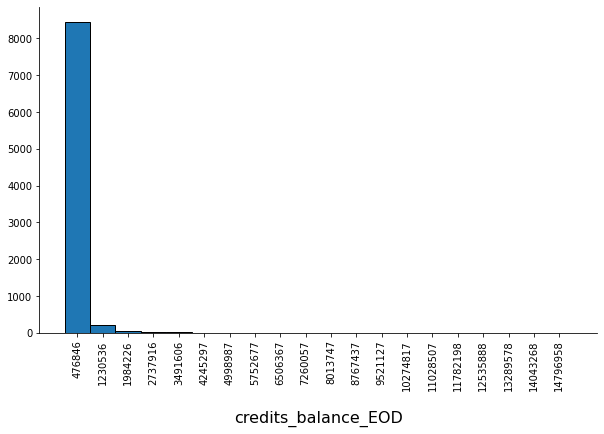

In [138]:
# Plotting the users with credit balance of above 100000 
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.credits_balance_EOD < 100000) ].index))
hist_of_numerical_feature(adjusted_df, 'credits_balance_EOD', n_bins)

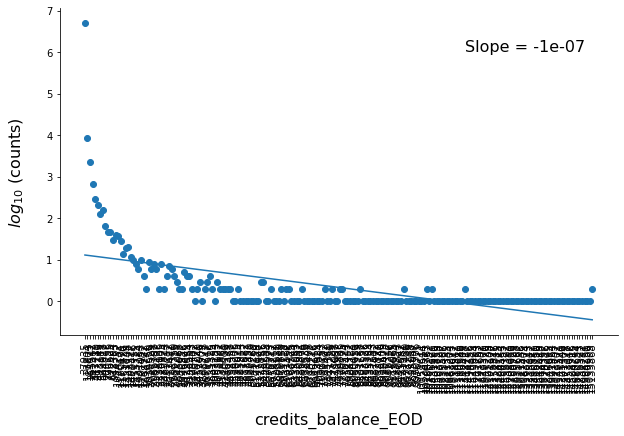

In [139]:
n_bins = 200
plot_log_scale(data_for_clustering, 'credits_balance_EOD', n_bins)

[back to top](#back_to_top)  <a id='coins_eod'></a>

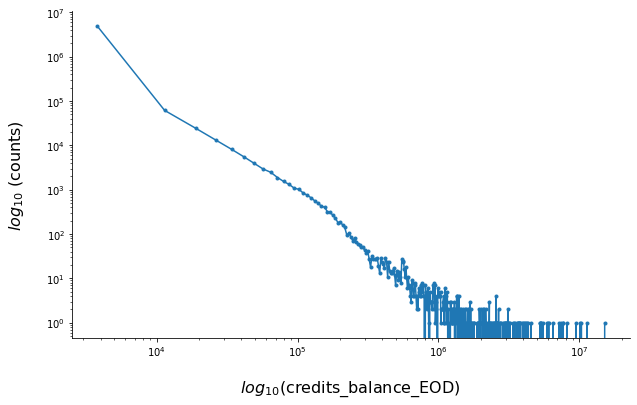

In [140]:
n_bins = 2000

plot_loglog_scale(data_for_clustering, 'credits_balance_EOD', n_bins)

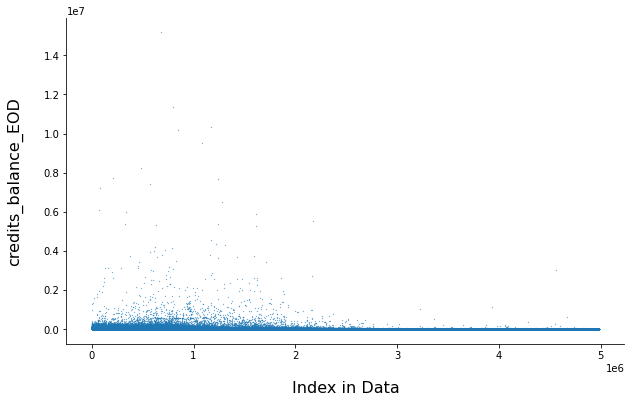

In [141]:
plot_data_by_index(data_for_clustering, 'credits_balance_EOD')

#### coins_balance_EOD

In [142]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "coins_balance_EOD")

print("The number of coins balance of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest number of coins is: {}\nThe highest is: {}".format(min_value, max_value))

The number of coins balance of the users in this data set span 788290 different values.
The lowest number of coins is: 0.0
The highest is: 1511280804.0


In [143]:
zero_balance = len(data_for_clustering[data_for_clustering["coins_balance_EOD"] == 0])
print("\nThere are {} users with *zero* coins balance at end of day.".format(zero_balance))
print("This is {:.2f}% of the users in the list.".format(zero_balance/len(data_for_clustering["coins_balance_EOD"])*100))


There are 591 users with *zero* coins balance at end of day.
This is 0.01% of the users in the list.


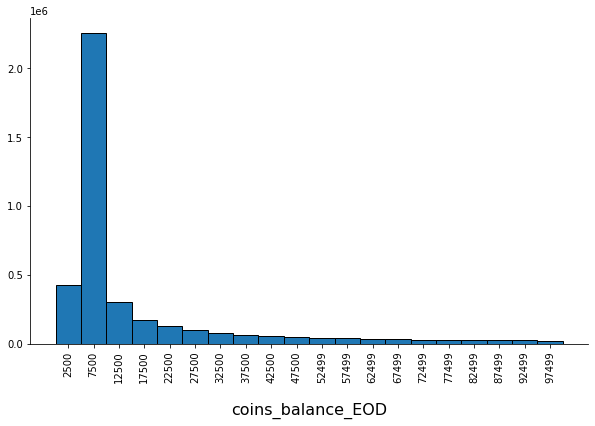

In [144]:
# Plotting the users with coins balance of below 100000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.coins_balance_EOD < 0) | (data_for_clustering.coins_balance_EOD >= 100000)].index))
hist_of_numerical_feature(adjusted_df, 'coins_balance_EOD', n_bins)

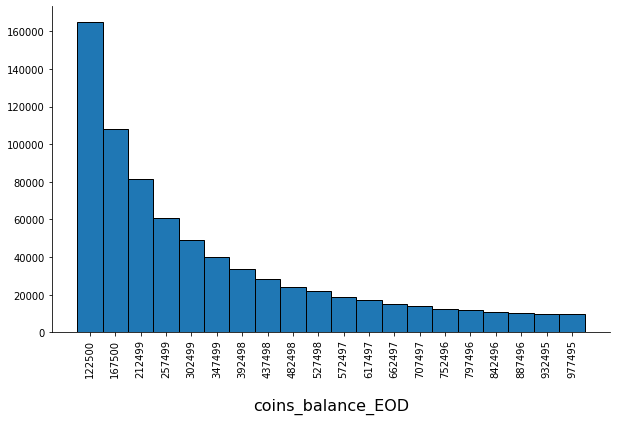

In [145]:
# Plotting the users with coins balance of above 100000 and below 1000000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.coins_balance_EOD < 100000) | (data_for_clustering.coins_balance_EOD >= 1000000)].index))
hist_of_numerical_feature(adjusted_df, 'coins_balance_EOD', n_bins)

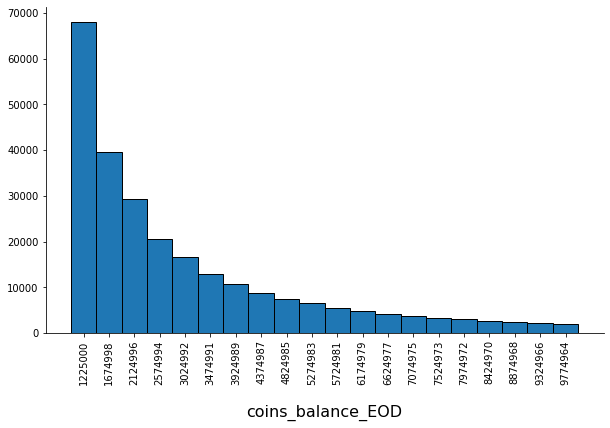

In [146]:
# Plotting the users with coins balance of above 1000000 and below 10000000
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.coins_balance_EOD < 1000000) | (data_for_clustering.coins_balance_EOD > 10000000)].index))
hist_of_numerical_feature(adjusted_df, 'coins_balance_EOD', n_bins)

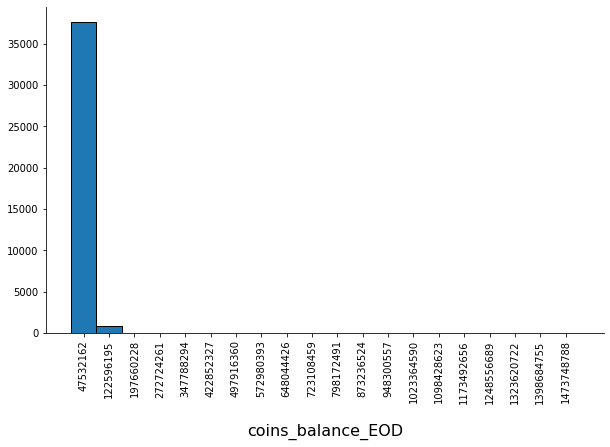

In [147]:
# Plotting the users with coins balance of above 10000000 
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.coins_balance_EOD < 10000000)].index))
hist_of_numerical_feature(adjusted_df, 'coins_balance_EOD', n_bins)

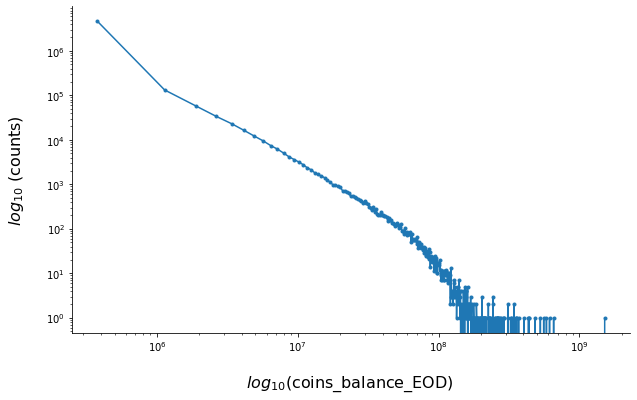

In [148]:
n_bins = 2000

plot_loglog_scale(data_for_clustering, 'coins_balance_EOD', n_bins)

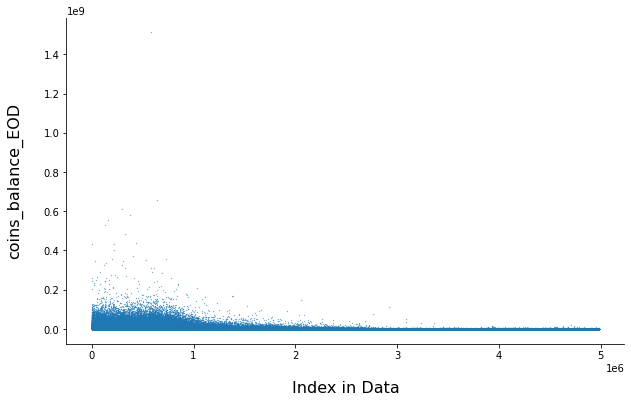

In [149]:
plot_data_by_index(data_for_clustering, 'coins_balance_EOD')

[back to top](#back_to_top)  <a id='bingo_rounds'></a>

#### number_of_bingo_rounds

In [150]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "number_of_bingo_rounds")

print("The number of bingo rounds of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest number of rounds is: {}\nThe highest is: {}".format(min_value, max_value))

The number of bingo rounds of the users in this data set span 302 different values.
The lowest number of rounds is: 0
The highest is: 433


In [151]:
zero_rounds = len(data_for_clustering[data_for_clustering["number_of_bingo_rounds"] == 0])
print("\nThere are {} users with *zero* rounds.".format(zero_rounds))
print("This is {:.2f}% of the users in the list.".format(zero_rounds/len(data_for_clustering["number_of_bingo_rounds"])*100))


There are 4395201 users with *zero* rounds.
This is 88.16% of the users in the list.


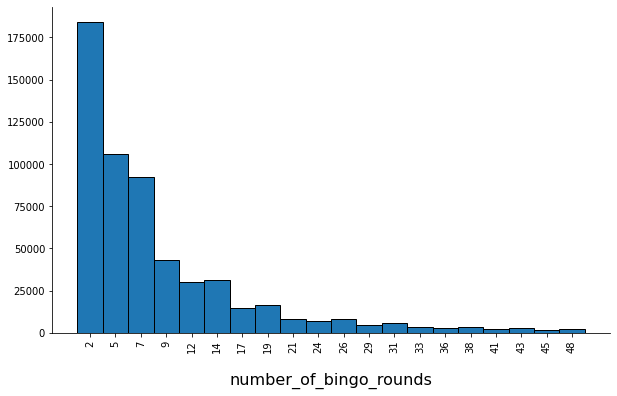

In [152]:
# Plotting the users with rounds of above 0 and below 50
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.number_of_bingo_rounds == 0) | (data_for_clustering.number_of_bingo_rounds >= 50)].index))
hist_of_numerical_feature(adjusted_df, 'number_of_bingo_rounds', n_bins)

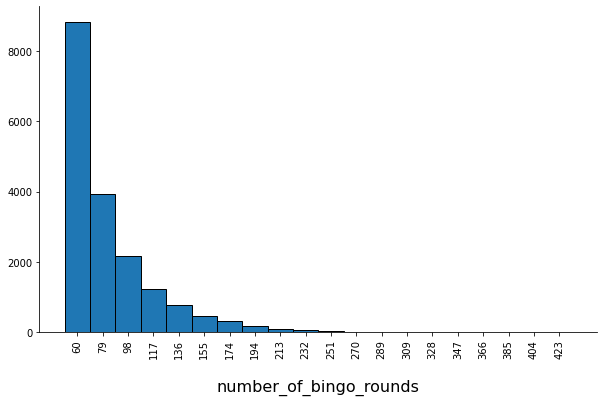

In [153]:
# Plotting the users with rounds of above 50 
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.number_of_bingo_rounds < 50)].index))
hist_of_numerical_feature(adjusted_df, 'number_of_bingo_rounds', n_bins)

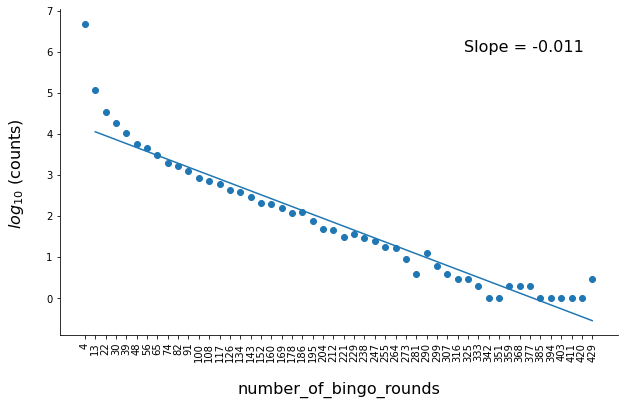

In [154]:
n_bins = 50
plot_log_scale(data_for_clustering, 'number_of_bingo_rounds', n_bins, start_at = 1)

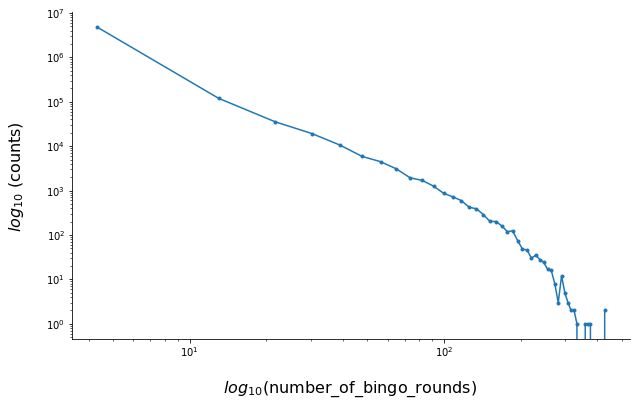

In [155]:
n_bins = 50

plot_loglog_scale(data_for_clustering, 'number_of_bingo_rounds', n_bins)

Looks like a power-law more than an exponential. 

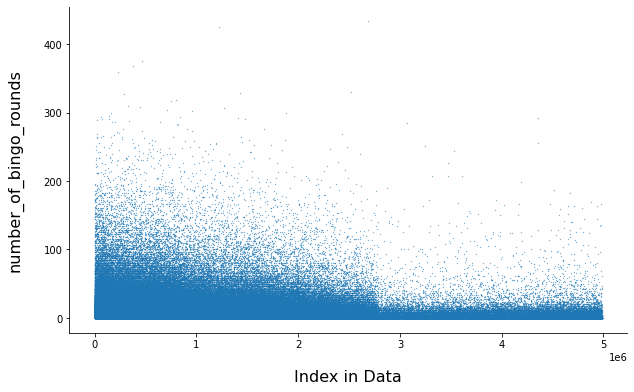

In [156]:
plot_data_by_index(data_for_clustering, 'number_of_bingo_rounds')

[back to top](#back_to_top)  <a id='total_rounds_modes_1_3'></a>

#### total_rounds_mode_1

In [157]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "total_rounds_mode_1")

print("The number of rounds mode 1 of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest number of rounds is: {}\nThe highest is: {}".format(min_value, max_value))

The number of rounds mode 1 of the users in this data set span 240 different values.
The lowest number of rounds is: 0
The highest is: 366


In [158]:
zero_rounds = len(data_for_clustering[data_for_clustering["total_rounds_mode_1"] == 0])
print("\nThere are {} users with *zero* rounds mode 1.".format(zero_rounds))
print("This is {:.2f}% of the users in the list.".format(zero_rounds/len(data_for_clustering["total_rounds_mode_1"])*100))


There are 4680342 users with *zero* rounds mode 1.
This is 93.88% of the users in the list.


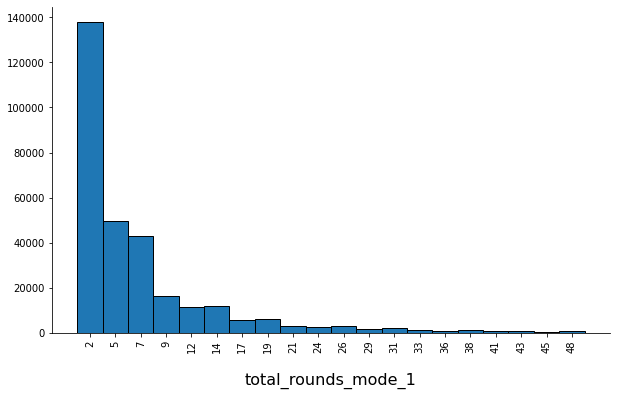

In [159]:
# Plotting the users with rounds of above 0 and below 50
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.total_rounds_mode_1 == 0) | (data_for_clustering.total_rounds_mode_1 >= 50)].index))
hist_of_numerical_feature(adjusted_df, 'total_rounds_mode_1', n_bins)

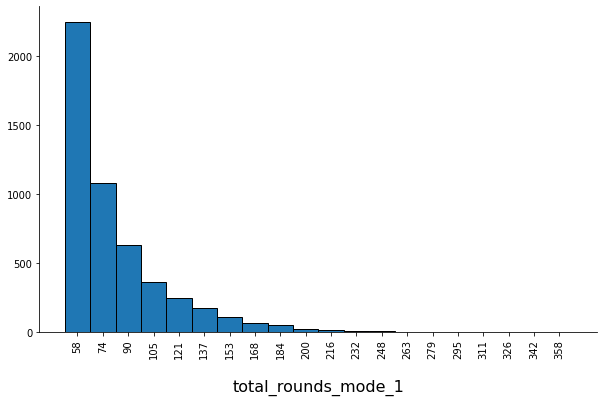

In [160]:
# Plotting the users with rounds of above 50 
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.total_rounds_mode_1 < 50)].index))
hist_of_numerical_feature(adjusted_df, 'total_rounds_mode_1', n_bins)

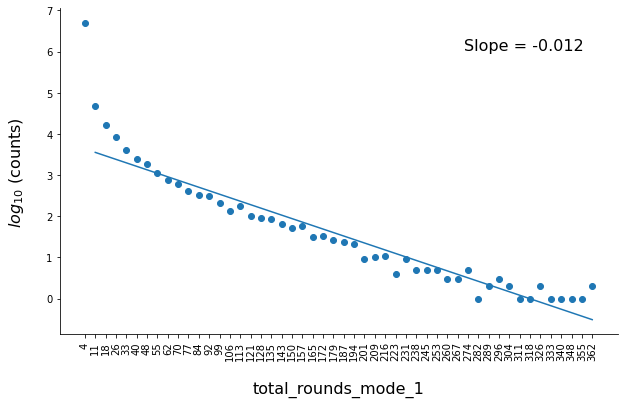

In [161]:
n_bins = 50
plot_log_scale(data_for_clustering, 'total_rounds_mode_1', n_bins, start_at = 1)

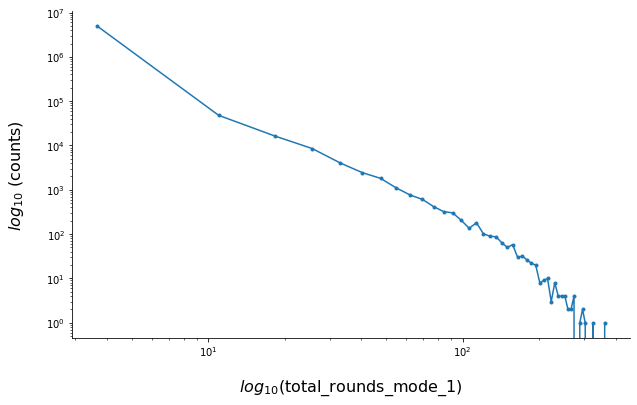

In [162]:
n_bins = 50

plot_loglog_scale(data_for_clustering, 'total_rounds_mode_1', n_bins)

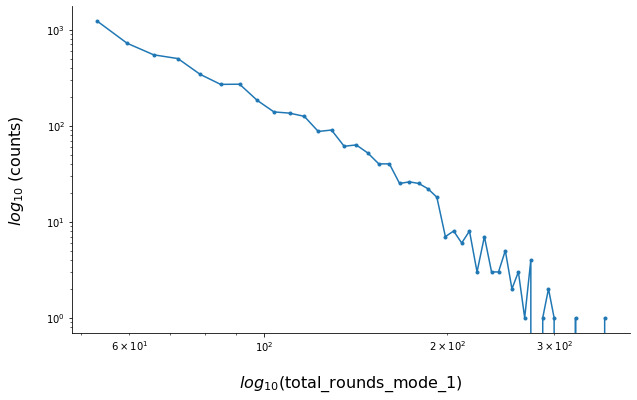

In [163]:
n_bins = 50
adjusted_df = adjusted_df.drop((adjusted_df[(adjusted_df.total_rounds_mode_1 == 0)].index))

plot_loglog_scale(adjusted_df, 'total_rounds_mode_1', n_bins)

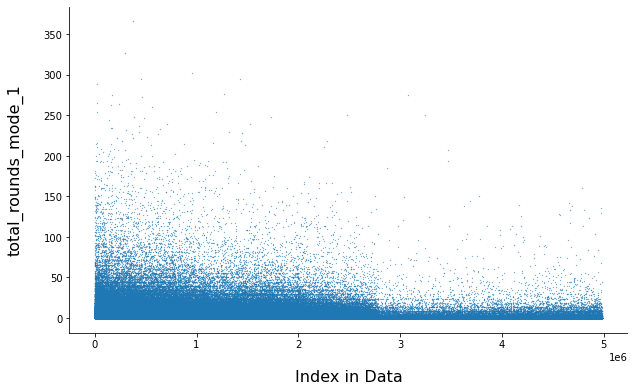

In [164]:
plot_data_by_index(data_for_clustering, 'total_rounds_mode_1')

#### total_rounds_mode_2

In [165]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "total_rounds_mode_2")

print("The number of rounds mode 2 of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest number of rounds is: {}\nThe highest is: {}".format(min_value, max_value))

The number of rounds mode 2 of the users in this data set span 231 different values.
The lowest number of rounds is: 0
The highest is: 318


In [166]:
zero_rounds = len(data_for_clustering[data_for_clustering["total_rounds_mode_2"] == 0])
print("\nThere are {} users with *zero* rounds mode 2.".format(zero_rounds))
print("This is {:.2f}% of the users in the list.".format(zero_rounds/len(data_for_clustering["total_rounds_mode_2"])*100))


There are 4737672 users with *zero* rounds mode 2.
This is 95.03% of the users in the list.


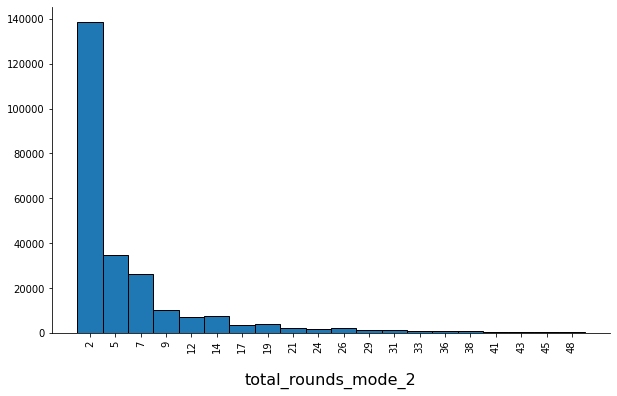

In [167]:
# Plotting the users with rounds of above 0 and below 50
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.total_rounds_mode_2 == 0) | (data_for_clustering.total_rounds_mode_2 >= 50)].index))
hist_of_numerical_feature(adjusted_df, 'total_rounds_mode_2', n_bins)

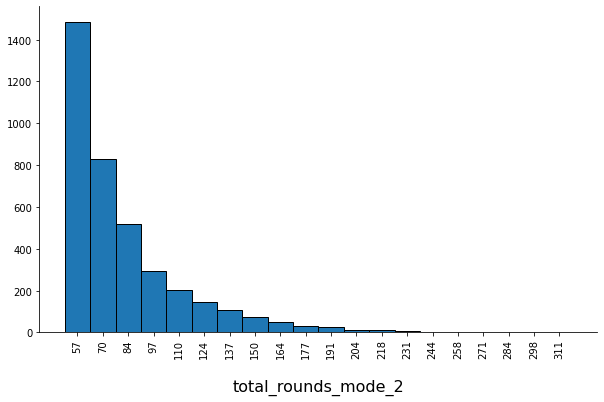

In [168]:
# Plotting the users with rounds of above 50 
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.total_rounds_mode_2 < 50)].index))
hist_of_numerical_feature(adjusted_df, 'total_rounds_mode_2', n_bins)

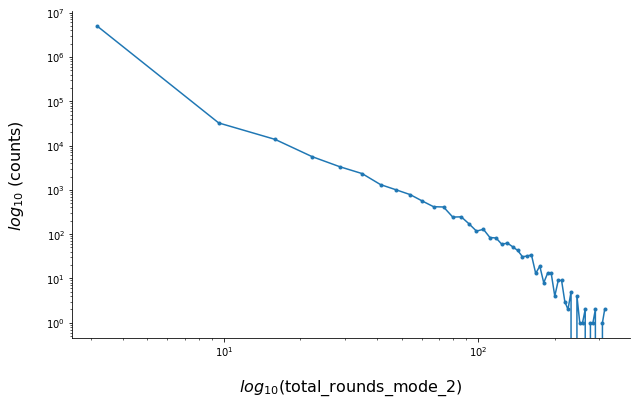

In [169]:
n_bins = 50

plot_loglog_scale(data_for_clustering, 'total_rounds_mode_2', n_bins)

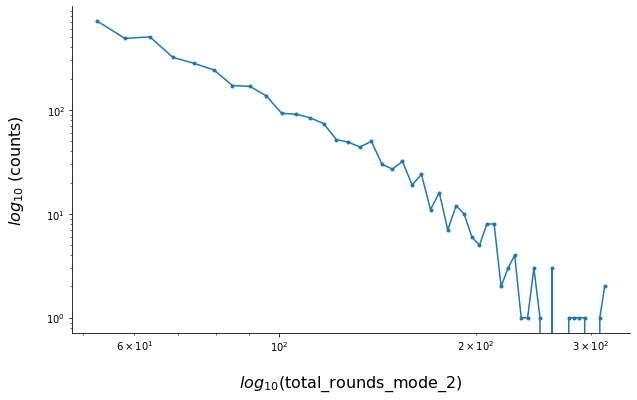

In [170]:
n_bins = 50
adjusted_df = adjusted_df.drop((adjusted_df[(adjusted_df.total_rounds_mode_2 == 0)].index))

plot_loglog_scale(adjusted_df, 'total_rounds_mode_2', n_bins)

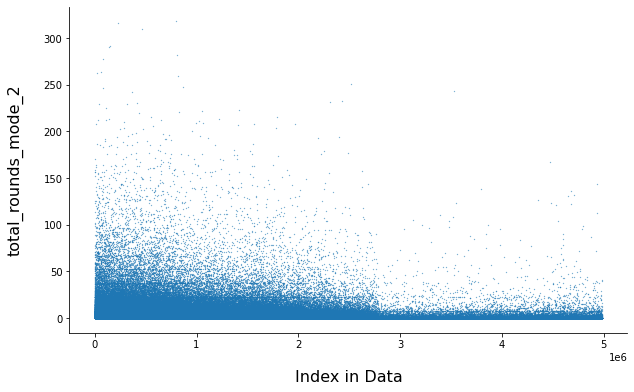

In [171]:
plot_data_by_index(data_for_clustering, 'total_rounds_mode_2')

#### total_rounds_mode_3

In [172]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "total_rounds_mode_3")

print("The number of rounds mode 3 of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest number of rounds is: {}\nThe highest is: {}".format(min_value, max_value))

The number of rounds mode 3 of the users in this data set span 171 different values.
The lowest number of rounds is: 0
The highest is: 272


In [173]:
zero_rounds = len(data_for_clustering[data_for_clustering["total_rounds_mode_3"] == 0])
print("\nThere are {} users with *zero* rounds mode 3.".format(zero_rounds))
print("This is {:.2f}% of the users in the list.".format(zero_rounds/len(data_for_clustering["total_rounds_mode_3"])*100))


There are 4866608 users with *zero* rounds mode 3.
This is 97.62% of the users in the list.


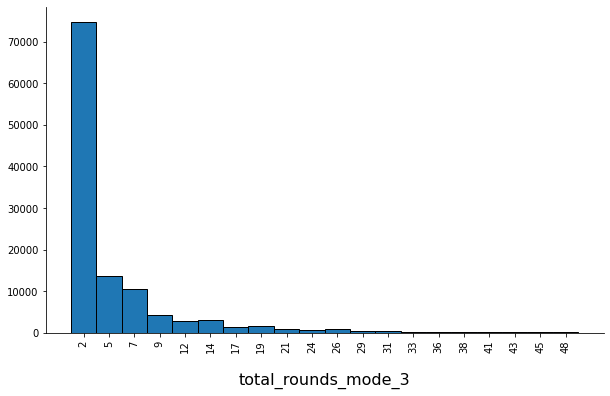

In [174]:
# Plotting the users with rounds of above 0 and below 50
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.total_rounds_mode_3 == 0) | (data_for_clustering.total_rounds_mode_3 >= 50)].index))
hist_of_numerical_feature(adjusted_df, 'total_rounds_mode_3', n_bins)

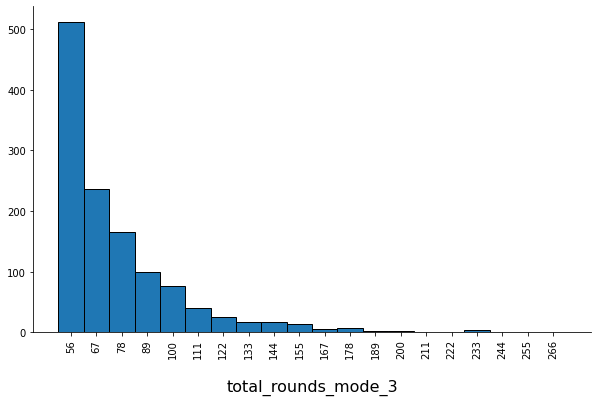

In [175]:
# Plotting the users with rounds of above 50 
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.total_rounds_mode_3 < 50)].index))
hist_of_numerical_feature(adjusted_df, 'total_rounds_mode_3', n_bins)

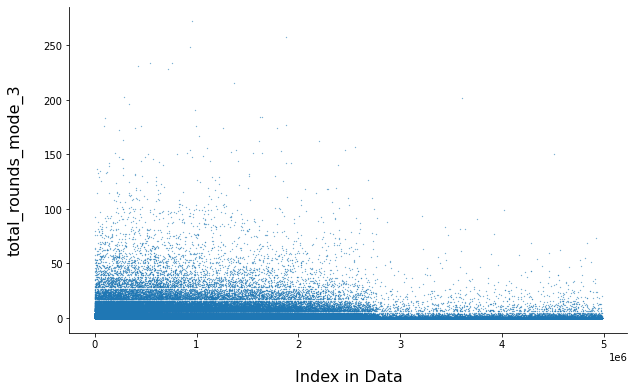

In [176]:
plot_data_by_index(data_for_clustering, 'total_rounds_mode_3')

[back to top](#back_to_top)  <a id='total_rounds_modes_4_6'></a>

#### total_rounds_mode_4

In [177]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "total_rounds_mode_4")

print("The number of rounds mode 4 of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest number of rounds is: {}\nThe highest is: {}".format(min_value, max_value))

The number of rounds mode 4 of the users in this data set span 160 different values.
The lowest number of rounds is: 0
The highest is: 267


In [178]:
zero_rounds = len(data_for_clustering[data_for_clustering["total_rounds_mode_4"] == 0])
print("\nThere are {} users with *zero* rounds mode 4.".format(zero_rounds))
print("This is {:.2f}% of the users in the list.".format(zero_rounds/len(data_for_clustering["total_rounds_mode_4"])*100))


There are 4906060 users with *zero* rounds mode 4.
This is 98.41% of the users in the list.


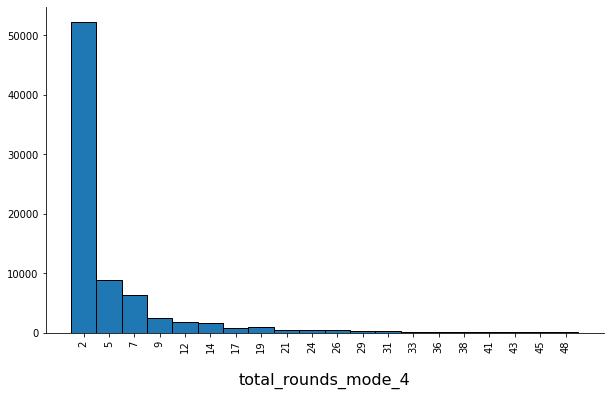

In [179]:
# Plotting the users with rounds of above 0 and below 50
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.total_rounds_mode_4 == 0) | (data_for_clustering.total_rounds_mode_4 >= 50)].index))
hist_of_numerical_feature(adjusted_df, 'total_rounds_mode_4', n_bins)

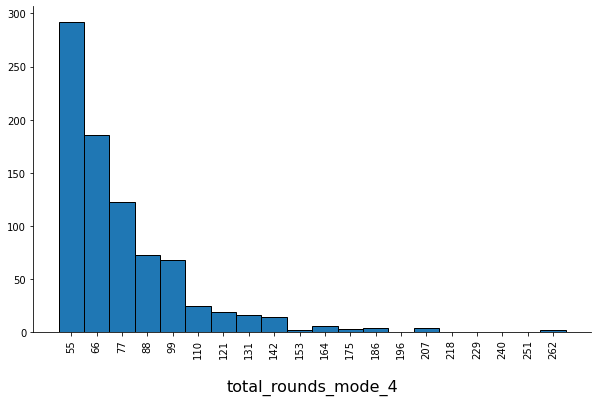

In [180]:
# Plotting the users with rounds of above 50 
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.total_rounds_mode_4 < 50)].index))
hist_of_numerical_feature(adjusted_df, 'total_rounds_mode_4', n_bins)

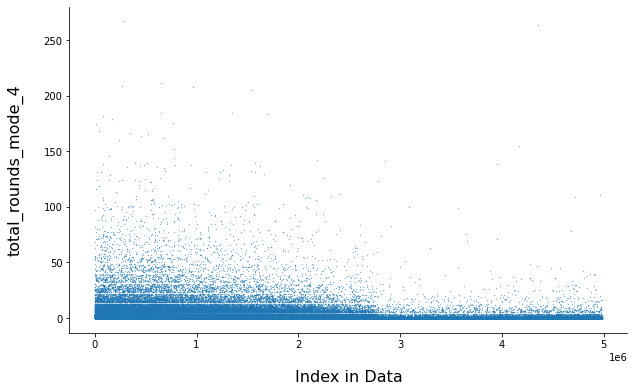

In [181]:
plot_data_by_index(data_for_clustering, 'total_rounds_mode_4')

#### total_rounds_mode_5

In [182]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "total_rounds_mode_5")

print("The number of rounds mode 5 of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest number of rounds is: {}\nThe highest is: {}".format(min_value, max_value))

The number of rounds mode 5 of the users in this data set span 152 different values.
The lowest number of rounds is: 0
The highest is: 238


In [183]:
zero_rounds = len(data_for_clustering[data_for_clustering["total_rounds_mode_5"] == 0])
print("\nThere are {} users with *zero* rounds mode 5.".format(zero_rounds))
print("This is {:.2f}% of the users in the list.".format(zero_rounds/len(data_for_clustering["total_rounds_mode_5"])*100))


There are 4941411 users with *zero* rounds mode 5.
This is 99.12% of the users in the list.


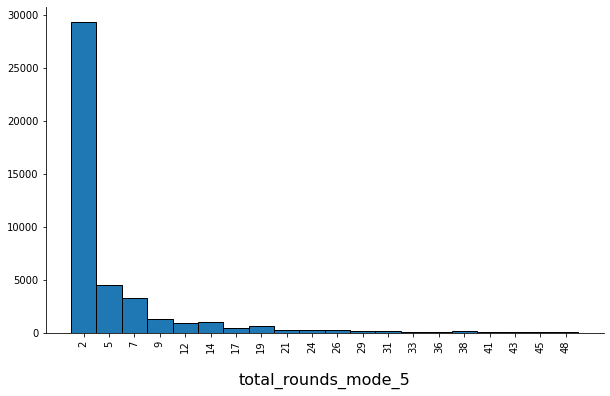

In [184]:
# Plotting the users with rounds of above 0 and below 50
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.total_rounds_mode_5 == 0) | (data_for_clustering.total_rounds_mode_5 >= 50)].index))
hist_of_numerical_feature(adjusted_df, 'total_rounds_mode_5', n_bins)

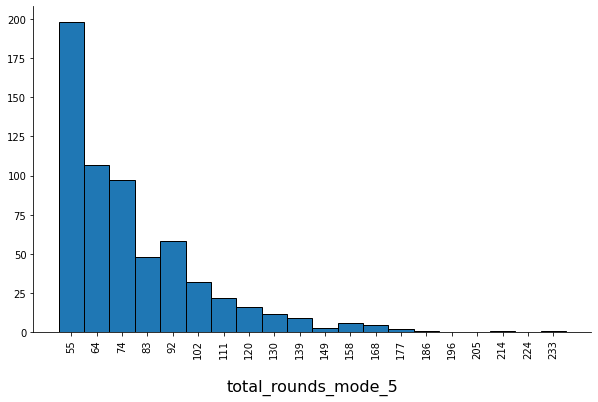

In [185]:
# Plotting the users with rounds of above 50 
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.total_rounds_mode_5 < 50)].index))
hist_of_numerical_feature(adjusted_df, 'total_rounds_mode_5', n_bins)

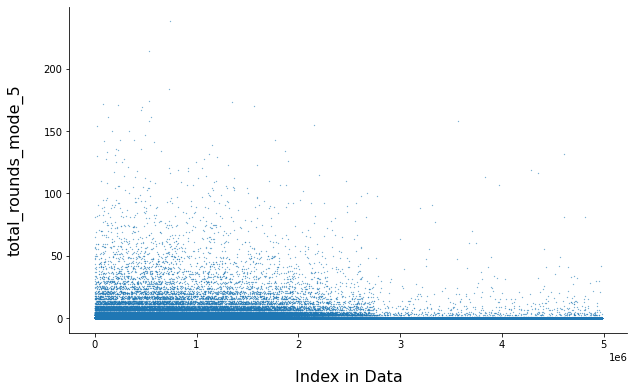

In [186]:
plot_data_by_index(data_for_clustering, 'total_rounds_mode_5')

#### total_rounds_mode_6

In [187]:
num_of_unique_values, min_value, max_value = get_basic_feature_char(data_for_clustering, "total_rounds_mode_6")

print("The number of rounds mode 6 of the users in this data set span {} different values.".format(num_of_unique_values))
print("The lowest number of rounds is: {}\nThe highest is: {}".format(min_value, max_value))

The number of rounds mode 6 of the users in this data set span 194 different values.
The lowest number of rounds is: 0
The highest is: 306


In [188]:
zero_rounds = len(data_for_clustering[data_for_clustering["total_rounds_mode_6"] == 0])
print("\nThere are {} users with *zero* rounds mode 6.".format(zero_rounds))
print("This is {:.2f}% of the users in the list.".format(zero_rounds/len(data_for_clustering["total_rounds_mode_6"])*100))


There are 4962171 users with *zero* rounds mode 6.
This is 99.54% of the users in the list.


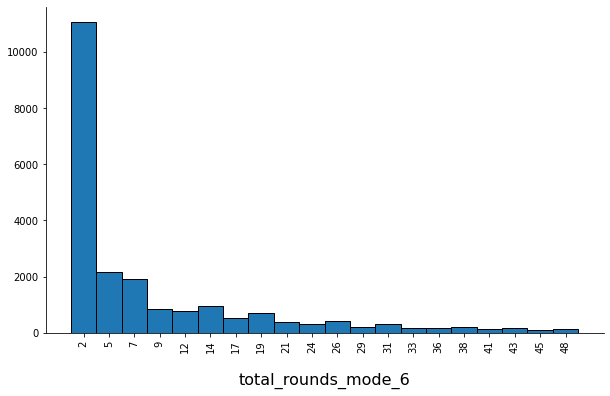

In [189]:
# Plotting the users with rounds of above 0 and below 50
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.total_rounds_mode_6 == 0) | (data_for_clustering.total_rounds_mode_6 >= 50)].index))
hist_of_numerical_feature(adjusted_df, 'total_rounds_mode_6', n_bins)

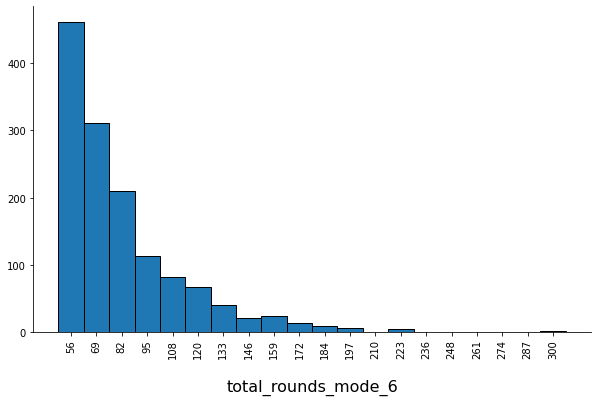

In [190]:
# Plotting the users with rounds of above 50 
n_bins = 20
adjusted_df = data_for_clustering.drop((data_for_clustering[(data_for_clustering.total_rounds_mode_6 < 50)].index))
hist_of_numerical_feature(adjusted_df, 'total_rounds_mode_6', n_bins)

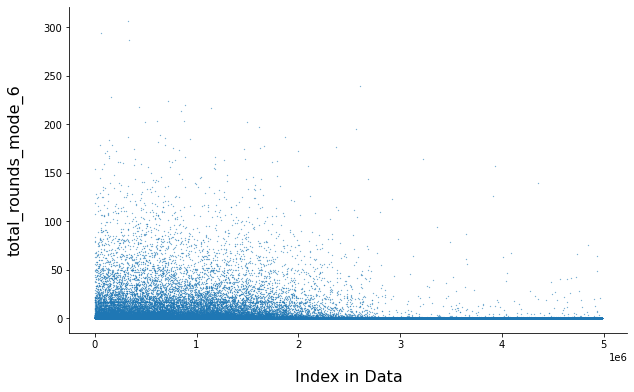

In [191]:
plot_data_by_index(data_for_clustering, 'total_rounds_mode_6')

[back to top](#back_to_top) 